### Unsupervised cell shape classification

This code is based on the [bioRxiv preprint](https://www.biorxiv.org/content/10.1101/623793v1.abstract) "A Methodology for Morphological Feature Extraction and Unsupervised Cell Classification" authored by Bhaskar, D., Lee, D., Knútsdóttir, H., Tan, C., Zhang, M., Dean, P., Roskelley, C., Keshet, L.

Additional source code is available on GitHub at:
https://github.com/dbhaskar92/Research-Scripts/tree/master

In [1]:
import os, copy, glob, random
import matplotlib

import scipy.io
import numpy as np
import pandas as pd
import string

from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import skater
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

import umap
import phate
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

from sklearn import preprocessing
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

from sklearn.decomposition import PCA

from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
def plot_dim_reduction(x, y, labels_num, mapping, sub, my_method):
    
    # x, y are DR coordinates. Labels_num are the encoded labels. I want triangles generated, circles real, nonused a lighter 
    # color. #sub is a list of colors
    
    fig, ax = plt.subplots(figsize=(3,3), dpi=500)
    n = len(x)
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    legend_list = []
    
    # Make the color dict (empty for annulus)
    color_dict = {"Healthy": CB_color_cycle[0], 'PMA': CB_color_cycle[1], 'fMLP': CB_color_cycle[2], 
                  'IFNg+GMCSF': CB_color_cycle[3], 'Cocktail': CB_color_cycle[4], 'LPS': CB_color_cycle[5], 
                  'Septic': CB_color_cycle[6]}
    
    # Make the marker dict (Change sim to Real when do neutrophils)
    marker_dict = {'Real':'o', 'Gen': '^'}
    
    # Make the legend list
    for key in mapping.keys():
        sub, og, witheld = key.split('_')
        my_alpha=0.9
        my_color = color_dict[sub]
        #if og=='Gen':
        #    my_color = adjust_lightness(my_color)
        my_marker = marker_dict[og]
        my_label = sub + ' ' + og# + ' ('+ witheld + ')'
        legend_list.append(mlines.Line2D([], [], color=my_color, marker=my_marker, linestyle='None',
                          markersize=1, alpha = my_alpha, label=my_label))
        ax.scatter([x[i] for i in range(n) if labels_num[i]==mapping[key]], [y[i] for i in range(n) if labels_num[i]==mapping[key]],
                   c = my_color, marker = my_marker, alpha=my_alpha, s=3)
        
    # Add rest of plot components
    ax.legend(handles=legend_list, bbox_to_anchor=(1, 1), fontsize=6, markerscale=4)
    ax.set_title('Healthy vs Septic ' + my_method)
    ax.set_xlabel(my_method+ " 1")
    ax.set_ylabel(my_method + " 2")
    return(fig, ax)
    
def adjust_lightness(color, amount=1.3):
    
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [3]:
# Import data (do healthy v sepsis v LPS 1.5 30 min first)
file_healthy = '../WitholdExperiments/LPS_1point5kpa_'
file_sep = '../WitholdExperiments/LPS(septic)_1point5kpa_'
healthy_real1 = pd.read_csv(file_healthy+'train_time1.csv')
healthy_real1['stim_stiff']="Healthy"
healthy_real1['origin']="Real" ##Not doing withold yet.
healthy_real2 = pd.read_csv(file_healthy+'test_time1.csv')
healthy_real2['stim_stiff']="Healthy"
healthy_real2['origin']="Real"
healthy_gen = pd.read_csv(file_healthy+'gen_time1.csv')
healthy_gen['stim_stiff'] = "Healthy"
healthy_gen['origin']='Gen'
sep_real1 = pd.read_csv(file_sep+'train_time1.csv')
sep_real1['stim_stiff']="Septic"
sep_real1['origin']="Real"
sep_real2 = pd.read_csv(file_sep+'test_time1.csv')
sep_real2['stim_stiff']="Septic"
sep_real2['origin']="Real"
sep_gen = pd.read_csv(file_sep+'gen_time1.csv')
sep_gen['stim_stiff']="Septic"
sep_gen['origin']= 'Gen'

# Combine all data
df = pd.concat([healthy_real1, healthy_real2])
df = pd.concat([df, healthy_gen])
df = pd.concat([df, sep_real1])
df = pd.concat([df, sep_real2])
df = pd.concat([df, sep_gen])
df = df.dropna()
df = df.reset_index()

# Make the stim/origin column
df['witheld']=['N' for i in range(np.shape(df)[0])]
df['class_label'] = [df['stim_stiff'][i]+'_'+df['origin'][i]+'_'+df['witheld'][i] for i in range(np.shape(df)[0])]

# Get file labels consistent
df['CellID_EXP'] = [mystring.replace('.', '-') for mystring in df['CellID_EXP']]
df['CellID_EXP'] = [mystring.replace('20200109', '2020-01-09') for mystring in df['CellID_EXP']]
df['CellID_EXP'] = [mystring.replace('20200130', '2020-01-30') for mystring in df['CellID_EXP']]
df['CellID_EXP'] = [mystring.replace('20190911', '2019-09-11') for mystring in df['CellID_EXP']]
df['CellID_EXP'] = [mystring.replace('1point5kPa', '1-5kPa') for mystring in df['CellID_EXP']]

df.head()

,index,cid,area1,perim_1sqrt21,equiv_diameter1,perimeter1,poly_perim1,poly_area1,ellipse_centroid_x1,ellipse_centroid_y1,...,rect_centroid_y1,rect_orient1,rect_ferret_max1,rect_ferret_min1,stim_stiff,origin,CellID_EXP,fullfilepath,witheld,class_label
0,0,1,151.9616,54.588594,13.909835,53.546900,53.868652,153.0240,826.367588,829.056267,...,829.056267,0.604267,16.805836,15.040789,Healthy,Real,LPS_1-5kPa_2020-07-01_xy01_A,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N
1,1,2,134.8352,53.004675,13.102576,52.448042,53.099762,135.6032,826.561800,827.330169,...,827.330169,-0.352668,15.164381,13.322924,Healthy,Real,LPS_1-5kPa_2020-07-01_xy03_A,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N
2,2,3,124.2112,58.739175,12.575795,57.392160,57.929867,125.5040,827.111913,830.122424,...,830.122424,0.761040,17.064855,12.000123,Healthy,Real,LPS_1-5kPa_2020-07-01_xy03_B,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N
3,3,4,104.0384,38.652918,11.509379,37.953263,38.283231,104.9216,828.660187,828.479577,...,828.479577,0.567580,12.419068,11.414001,Healthy,Real,LPS_1-5kPa_2020-07-01_xy07_A,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N
4,4,5,125.0816,49.319965,12.619780,48.115467,48.343494,126.1696,829.403602,827.704257,...,827.704257,0.411976,14.832598,12.478157,Healthy,Real,LPS_1-5kPa_2020-07-01_xy08_B,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N


In [4]:
sub_list = ['Healthy', 'Septic']

In [5]:
feats = ['area1', 'perim_1sqrt21', 'equiv_diameter1', 'perimeter1',
       'poly_perim1', 'poly_area1', 'ellipse_eccentricity1', 'ellipse_major_ax1',
       'ellipse_minor_ax1', 'ellipse_orient1', 'ellipse_area1',
       'ellipse_perim1', 'ellipse_var1', 'circle_radius1', 'circle_perim1', 'circle_area1',
       'circle_var1', 'eroded_perim1', 'eroded_area1', 'bdy_mean_curvature1',
       'bdy_std_curvature1', 'bdy_num_protrusions1', 'bdy_num_indentations1',
       'bdy_max_curvature1', 'bdy_min_curvature1', 'shape_extent1',
       'shape_euler1', 'shape_solidity1', 'shape_compactness1',
       'shape_elongation1', 'shape_convexity1', 'shape_circularity1', 'rect_orient1', 'rect_ferret_max1', 
       'rect_ferret_min1']

#### UMAP Embedding

In [6]:
X = df[feats].fillna(0).to_numpy()
y = df['class_label'].fillna(0).to_numpy()

In [7]:
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(y)
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [8]:
mapping

{'Healthy_Gen_N': 0,
 'Healthy_Real_N': 1,
 'Septic_Gen_N': 2,
 'Septic_Real_N': 3}

In [9]:
emb_umap = umap.UMAP(n_neighbors=5, random_state=42).fit(X)

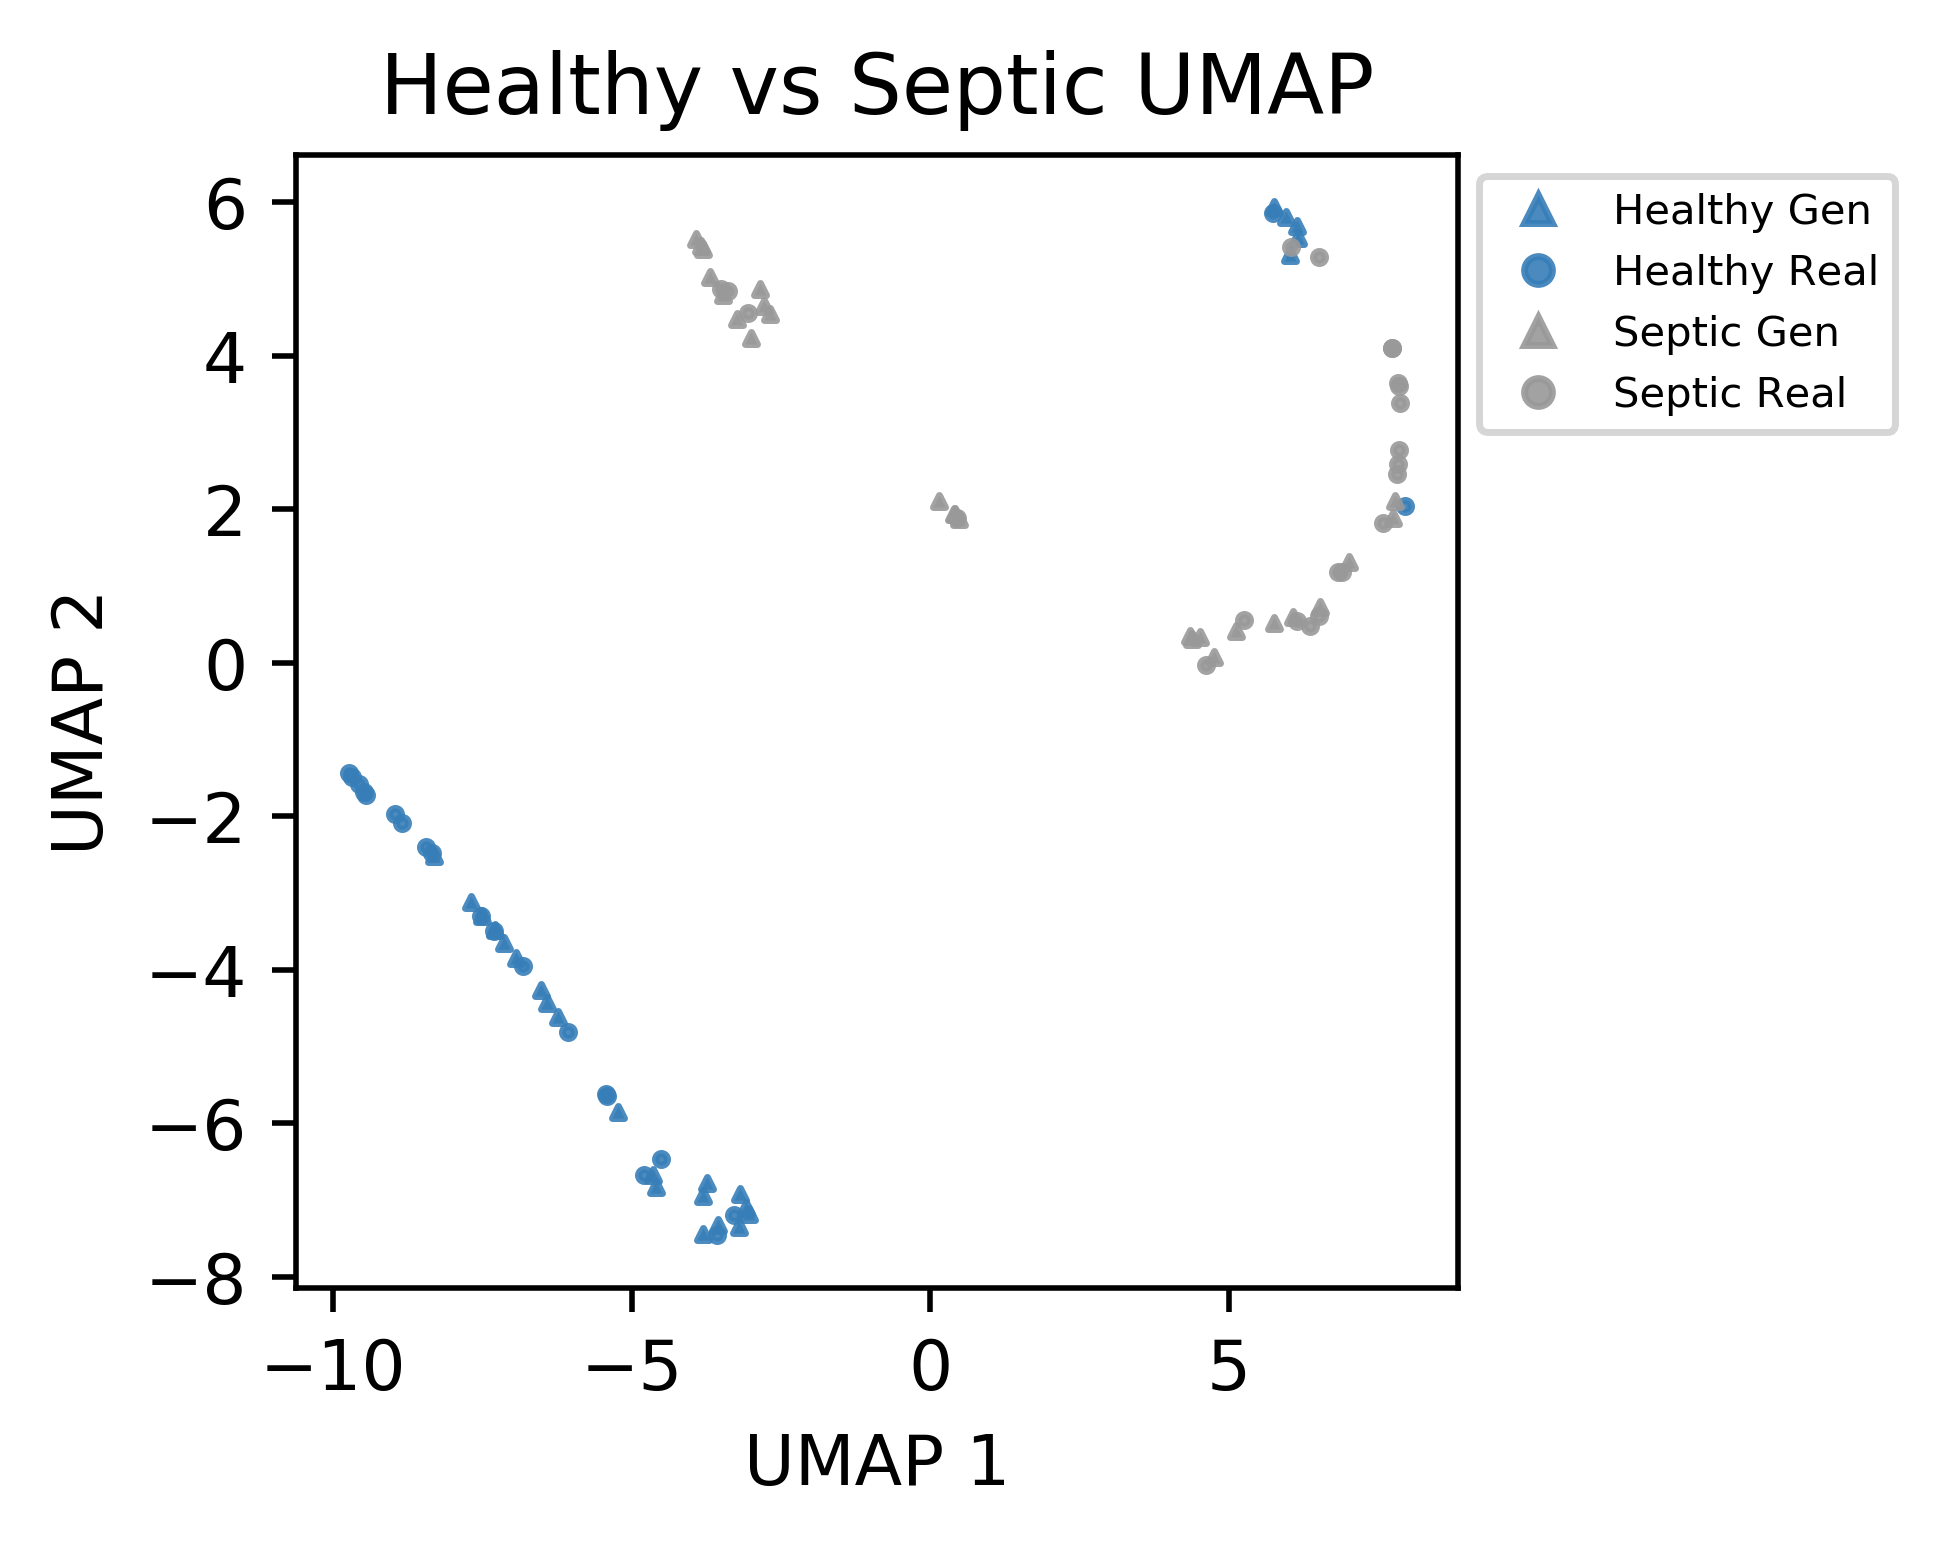

In [10]:
umapplot = plot_dim_reduction(emb_umap.embedding_[:, 0], emb_umap.embedding_[:, 1], labels_encoded, mapping=mapping, sub=sub_list, my_method = "UMAP")
umapplot[0].savefig("healthysep_UMAP.pdf", format="pdf")

In [96]:
umapplot[0].savefig("healthysep_UMAP.pdf", format="pdf", bbox_inches="tight")

#### PHATE embedding

In [11]:
phate_operator = phate.PHATE(n_jobs=-2)
emb_phate = phate_operator.fit_transform(X)

Calculating PHATE...
  Running PHATE on 93 observations and 35 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.01 seconds.
Calculated PHATE in 0.15 seconds.


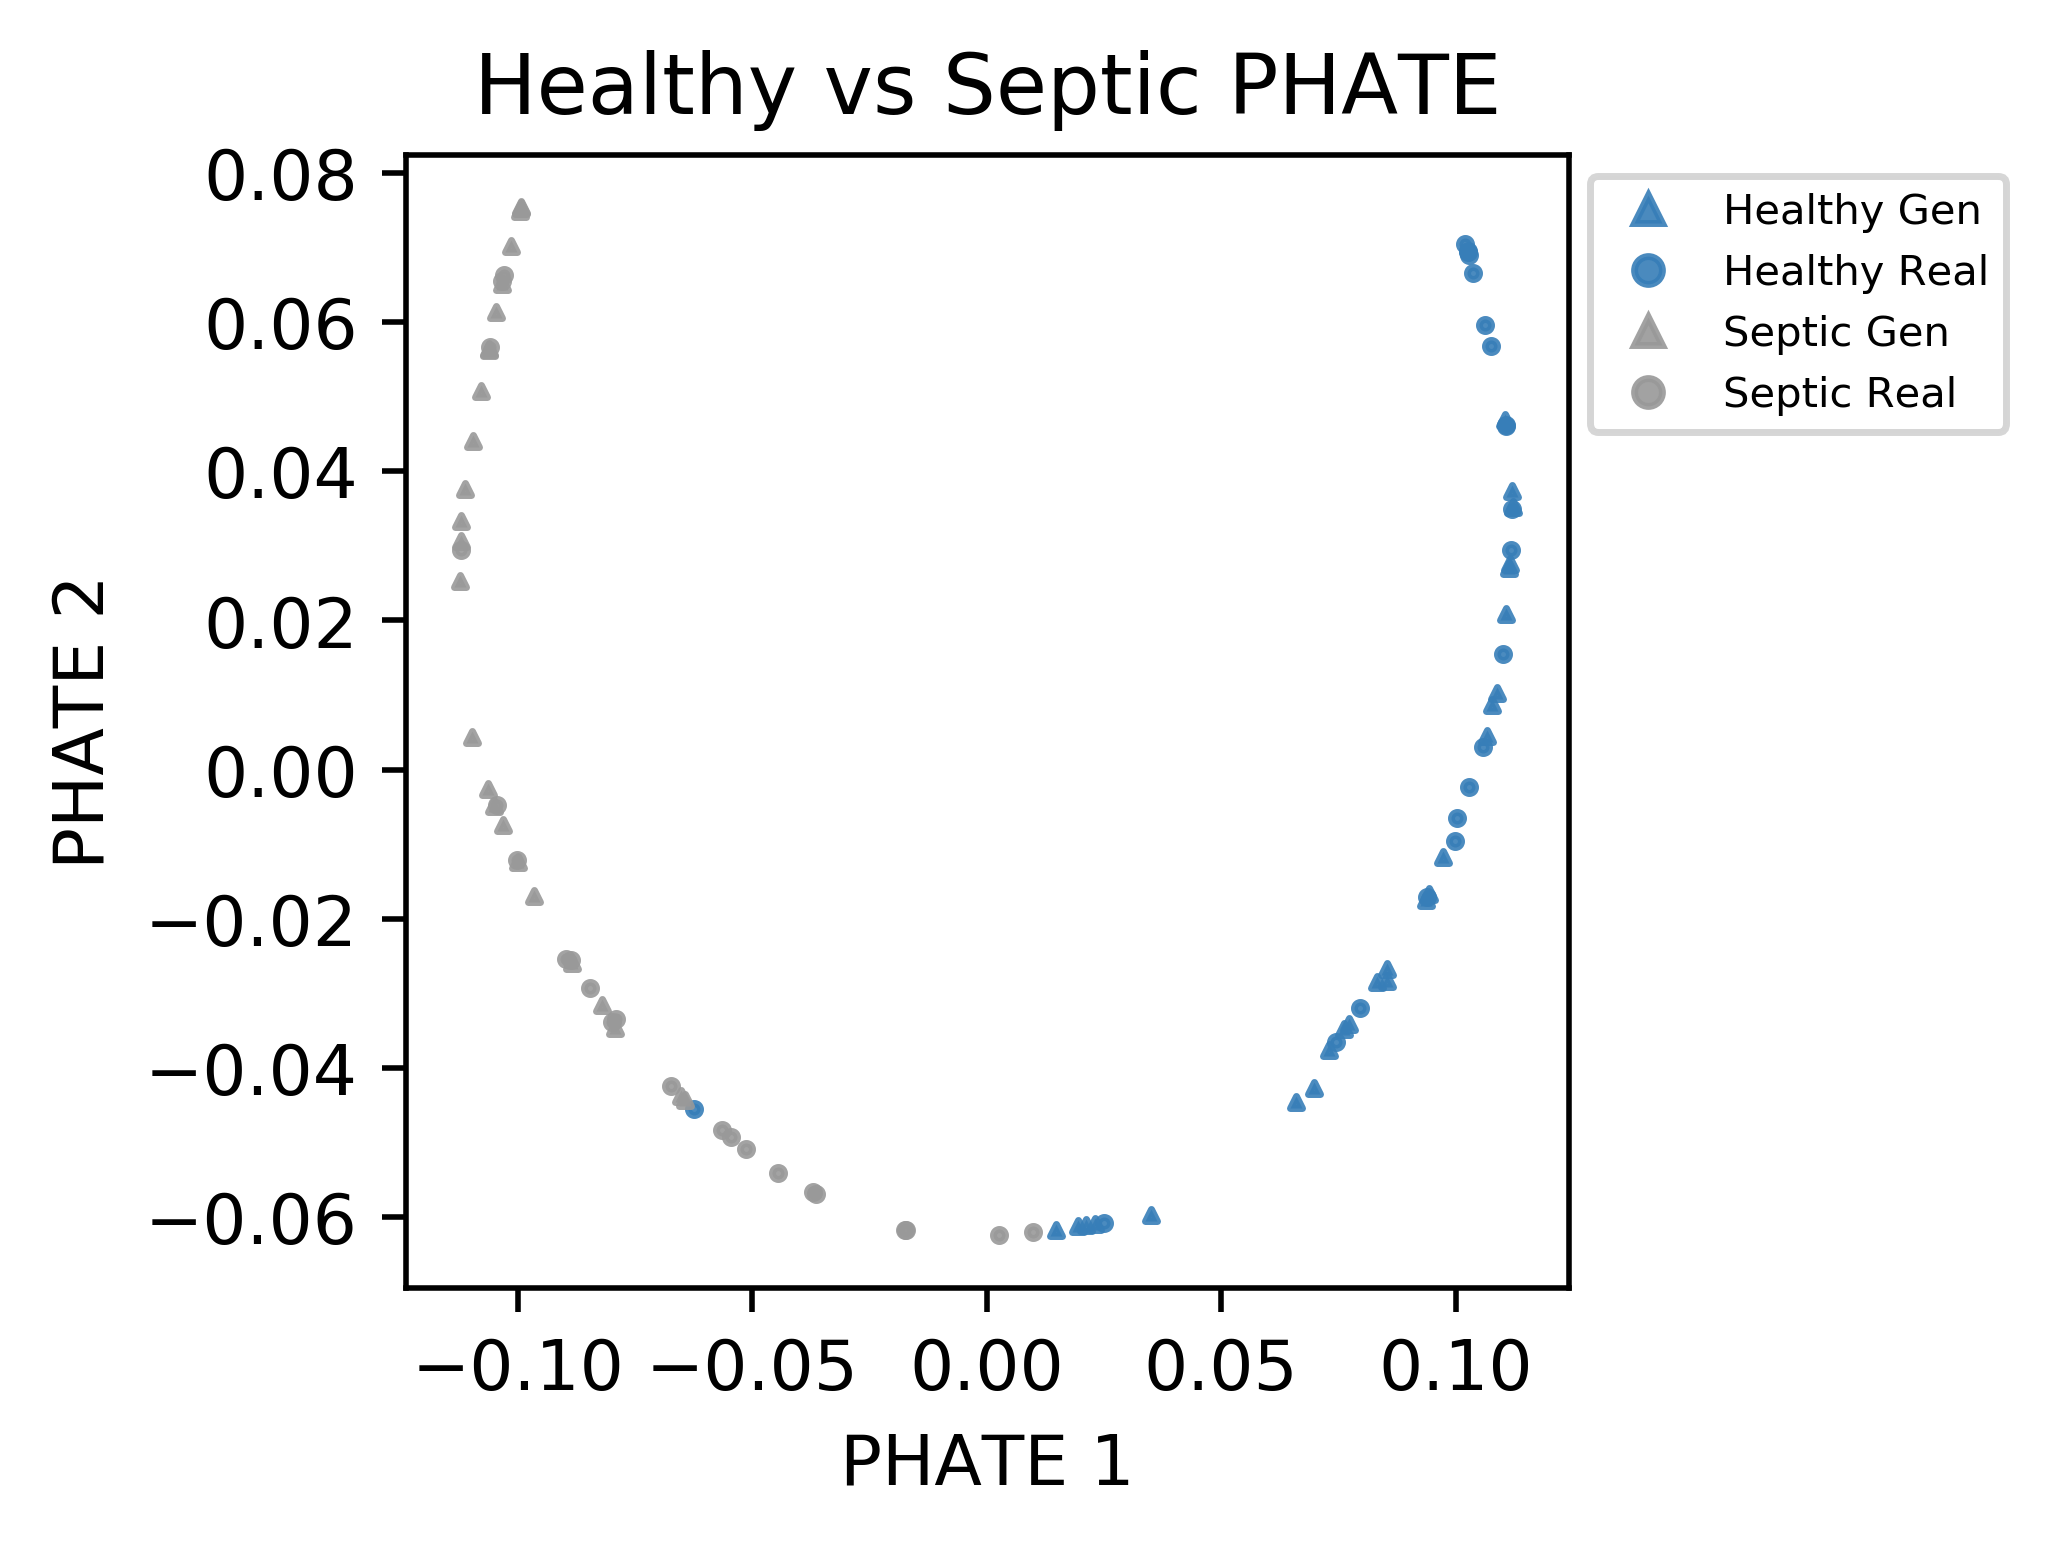

In [12]:
phateplot = plot_dim_reduction(emb_phate[:,0], emb_phate[:,1], labels_encoded, mapping=mapping, sub = sub_list, my_method="PHATE")
phateplot[0].savefig("healthysep_phate.pdf", format="pdf")

In [95]:
pcaplot[0].savefig("healthysep_PCA.pdf", format="pdf", bbox_inches="tight")

#### PCA Embedding

In [13]:
pca = PCA(n_components=2)
emb_pca = pca.fit(X).transform(X)

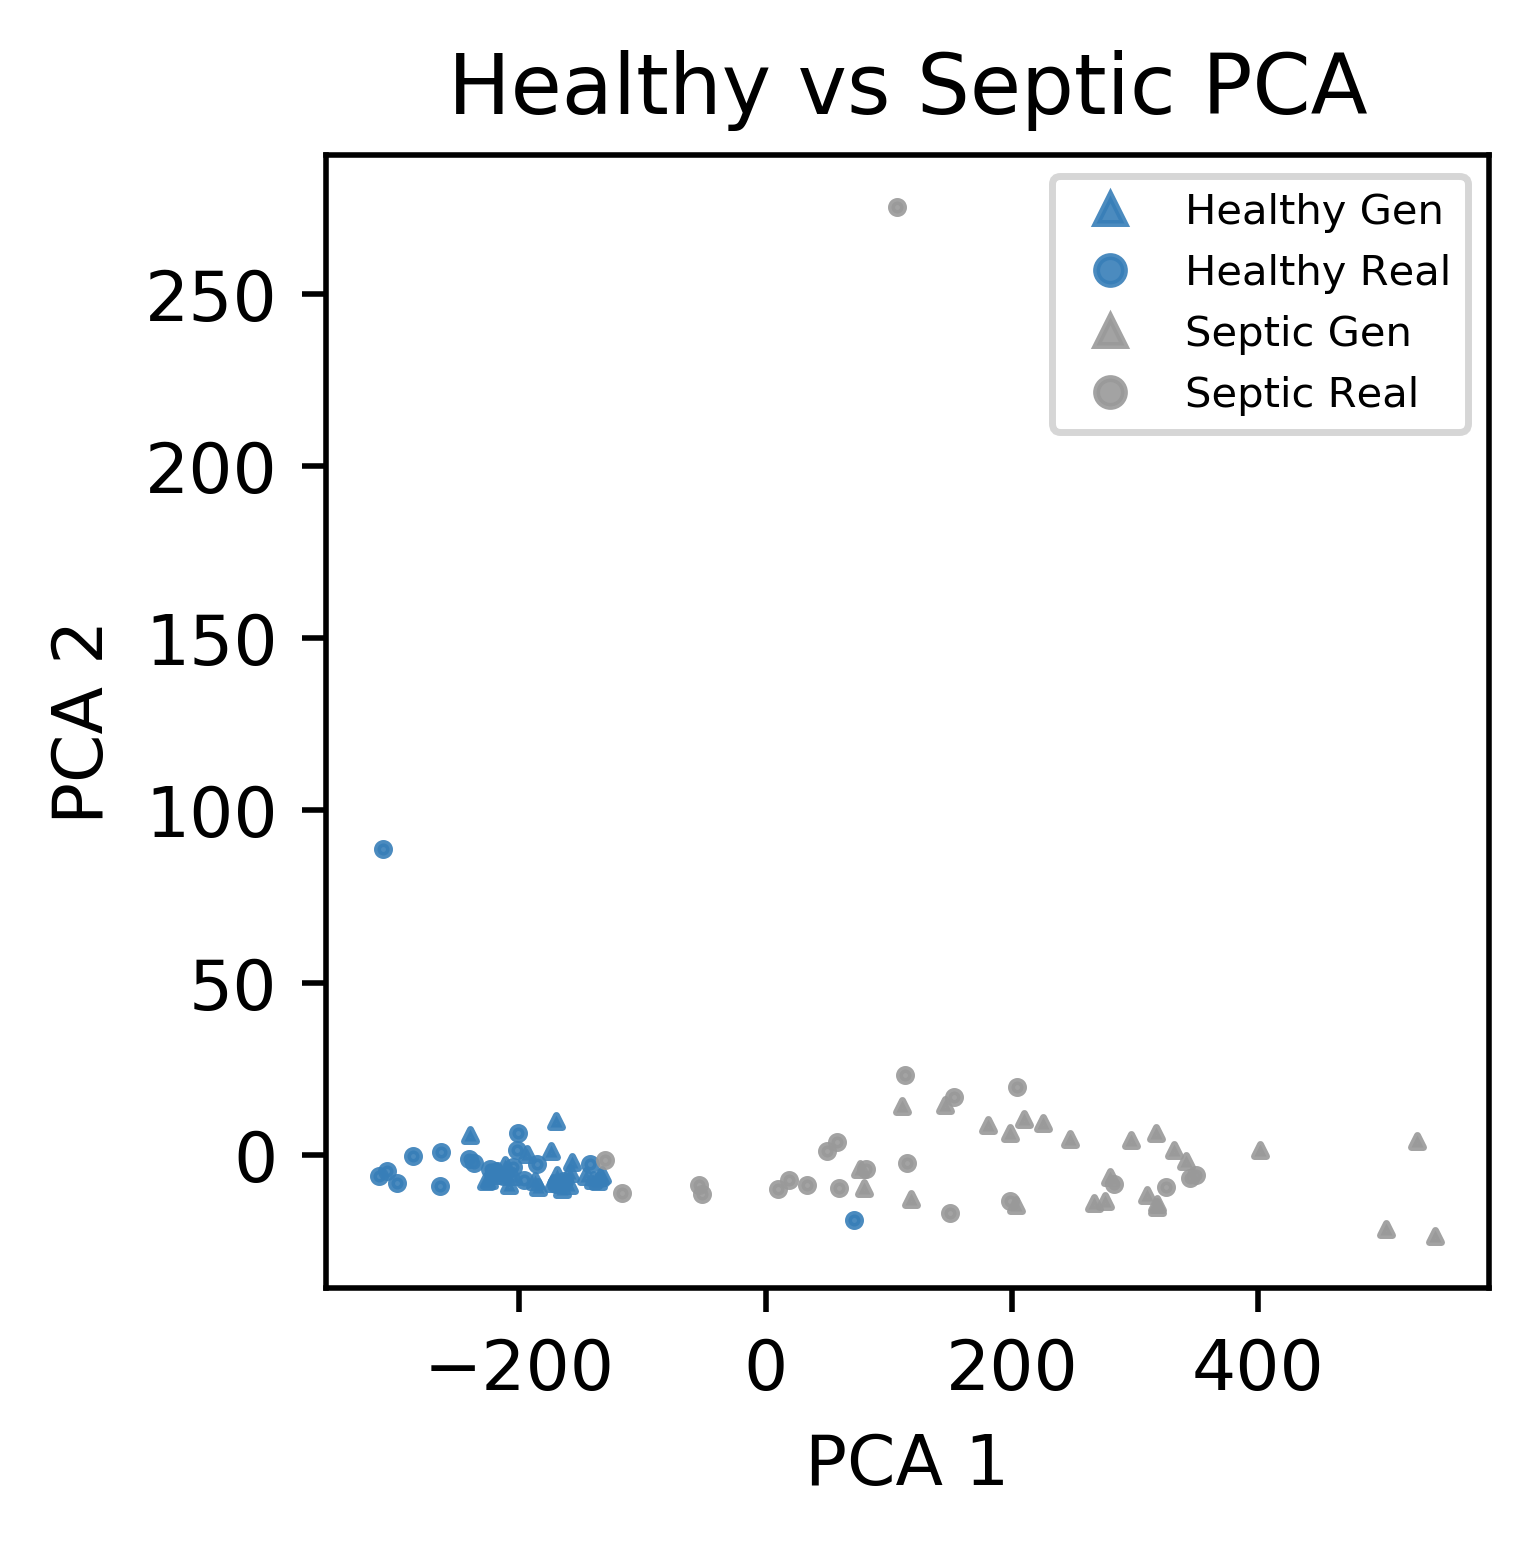

In [14]:
pcaplot = plot_dim_reduction(emb_pca[:,0], emb_pca[:,1], labels_encoded, mapping=mapping, sub = sub_list, my_method="PCA")
pcaplot[0].savefig("healthysep_PCA.pdf", format="pdf")

In [94]:
pcaplot[0].savefig("healthysep_PCA.pdf", format="pdf", bbox_inches='tight')

In [15]:
my_pc=pd.DataFrame(np.transpose(pca.components_), columns=['PC1', 'PC2'], index=feats)
my_pc_abs = abs(my_pc)
my_pc_abs.sort_values(by='PC1', ascending=False)

,PC1,PC2
ellipse_area1,0.471379,0.233568
circle_area1,0.454158,0.243907
poly_area1,0.426221,0.099147
area1,0.424257,0.093824
eroded_area1,0.412486,0.844470
perim_1sqrt21,0.091824,0.206106
poly_perim1,0.089376,0.200901
eroded_perim1,0.089276,0.160168
perimeter1,0.088190,0.199813
circle_perim1,0.053319,0.029734


In [16]:
my_pc_abs.sort_values(by='PC2', ascending=False)

,PC1,PC2
eroded_area1,0.412486,0.844470
circle_area1,0.454158,0.243907
ellipse_area1,0.471379,0.233568
perim_1sqrt21,0.091824,0.206106
poly_perim1,0.089376,0.200901
perimeter1,0.088190,0.199813
eroded_perim1,0.089276,0.160168
poly_area1,0.426221,0.099147
area1,0.424257,0.093824
rect_ferret_max1,0.025800,0.047108


#### Vanilla Autoencoder (AE)

In [17]:
device = torch.device("cpu")

class Encoder(nn.Module):
    
    def __init__(self, encoder_layers):
    
        super(Encoder,self).__init__()
        
        self.encoder = nn.ModuleList()
        for i in range(len(encoder_layers) - 1):
            self.encoder.append(nn.Linear(encoder_layers[i], encoder_layers[i + 1]))
            if i != len(encoder_layers) - 2:  
                self.encoder.append(nn.BatchNorm1d(encoder_layers[i + 1]))  
                self.encoder.append(nn.Tanh())                           

    def forward(self, x):
    
        for layer in self.encoder:
            x = layer(x)
        return x
    
class Decoder(nn.Module):

    def __init__(self, decoder_layers):
        
        super(Decoder, self).__init__()
        
        self.decoder = nn.ModuleList()
        for i in range(len(decoder_layers) - 1):
            self.decoder.append(nn.Linear(decoder_layers[i], decoder_layers[i + 1]))
            if i != len(decoder_layers) - 2:  
                self.decoder.append(nn.BatchNorm1d(decoder_layers[i + 1])) 
                self.decoder.append(nn.Tanh())              # nn.LeakyReLU(), nn.Sigmoid()            

    def forward(self, x):
        
        for layer in self.decoder:
            x = layer(x)
        return x

class Dataset(torch.utils.data.Dataset):

    'Characterizes a dataset for PyTorch'
    def __init__(self, X_train, y_label):

        self.X_train = X_train
        self.y_labels = y_label

    def __len__(self):
    
        'Denotes the total number of samples'
        return self.X_train.shape[0]

    def __getitem__(self, index):
    
        'Generates one sample of data'
        return self.X_train[index,:], self.y_labels[index]
    
def train_AE(learning_rate, n_epochs, feat_vec, grnd_truth, chk_fname):
    
    input_dim = feat_vec.shape[1]
    manifold_dim = 2
    
    print("Num. Features " + str(input_dim))
    
    enc_arch = [input_dim, 24, 16, 8, 4, manifold_dim]
    dec_arch = [manifold_dim, 4, 8, 16, 24, input_dim]

    encoder = Encoder(enc_arch)
    decoder = Decoder(dec_arch)
    
    params = list(encoder.parameters()) + list(decoder.parameters())

    optimizer = torch.optim.Adam(params, lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    data_params = {'batch_size': 64, 'shuffle': True, 'num_workers': 2} #Had to set num_workers to 0 for windows
    
    training_set = Dataset(feat_vec, grnd_truth)
    dataloader = torch.utils.data.DataLoader(training_set, **data_params)
    
    loss_vals = []
    
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    for epoch in range(1, n_epochs+1):

        epoch_losses = 0.0

        for data_batch, data_batch_params in dataloader:

            optimizer.zero_grad()
            y = data_batch_params
            
            data_batch = data_batch.float()
            
            z = encoder(data_batch)
            output = decoder(z)
            
            loss = criterion(output, data_batch)

            epoch_losses += loss

            loss.backward()
            optimizer.step()

        epoch_losses /= data_params['batch_size']

        tot_loss = epoch_losses.detach().numpy()

        if epoch % 50 == 0:
            print(f"Epoch ({epoch}/{n_epochs})\tNet Loss: {tot_loss}")
            
        loss_vals.append(tot_loss)
        
    torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, chk_fname)
    
    return loss_vals, enc_arch, dec_arch

def transform_AE(chk_fname, enc_arch, dec_arch, feat_vec, grnd_truth):
    
    encoder = Encoder(enc_arch)
    decoder = Decoder(dec_arch)

    checkpoint = torch.load(chk_fname)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    
    data_params = {'batch_size': 64, 'shuffle': False, 'num_workers': 2}
    training_set = Dataset(feat_vec, grnd_truth)
    dataloader = torch.utils.data.DataLoader(training_set, **data_params)
    
    encoder.eval()
    
    embed_x = []
    embed_y = []
    embed_label = []

    with torch.no_grad():

        for data_batch, data_batch_params in dataloader:

            data_batch = data_batch.float()

            z = encoder(data_batch)
            embed_npy = z.detach().numpy()
            
            embed_x.extend(embed_npy[:,0])
            embed_y.extend(embed_npy[:,1])
            
            embed_label.extend(data_batch_params)
            
    embed_x = np.asarray(embed_x)
    embed_y = np.asarray(embed_y)
    
    return (embed_x, embed_y, embed_label)

def plot_loss(n_epochs, loss_vals, title_str):
    
    plt.figure(figsize=(3,1), dpi=300)
    plt.plot(np.arange(n_epochs), loss_vals, linewidth=0.7)
    plt.title(title_str, fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.xlabel("Epochs", fontsize=7)
    plt.ylabel("Total Loss", fontsize=7)
    plt.show()

Num. Features 35
Epoch (50/500)	Net Loss: 0.011442959308624268
Epoch (100/500)	Net Loss: 0.0076528266072273254
Epoch (150/500)	Net Loss: 0.007275751326233149
Epoch (200/500)	Net Loss: 0.007186042610555887
Epoch (250/500)	Net Loss: 0.006104087457060814
Epoch (300/500)	Net Loss: 0.0057596853002905846
Epoch (350/500)	Net Loss: 0.006155323702841997
Epoch (400/500)	Net Loss: 0.006505872122943401
Epoch (450/500)	Net Loss: 0.005874983966350555
Epoch (500/500)	Net Loss: 0.004427644424140453


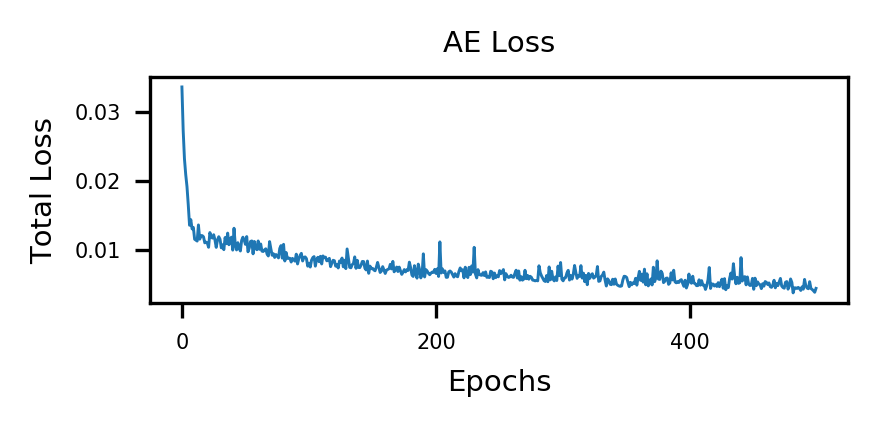

In [18]:
n_epochs = 500

X_std = StandardScaler().fit_transform(X)

(loss_vals, enc_arch, dec_arch) = train_AE(5e-3, n_epochs, X_std, y, "TDA_AE_model_healthy_sepsis.chk")

(AE_x, AE_y, AE_lab) = transform_AE("TDA_AE_model_healthy_sepsis.chk", enc_arch, dec_arch, X_std, y)

plot_loss(n_epochs, loss_vals, "AE Loss")

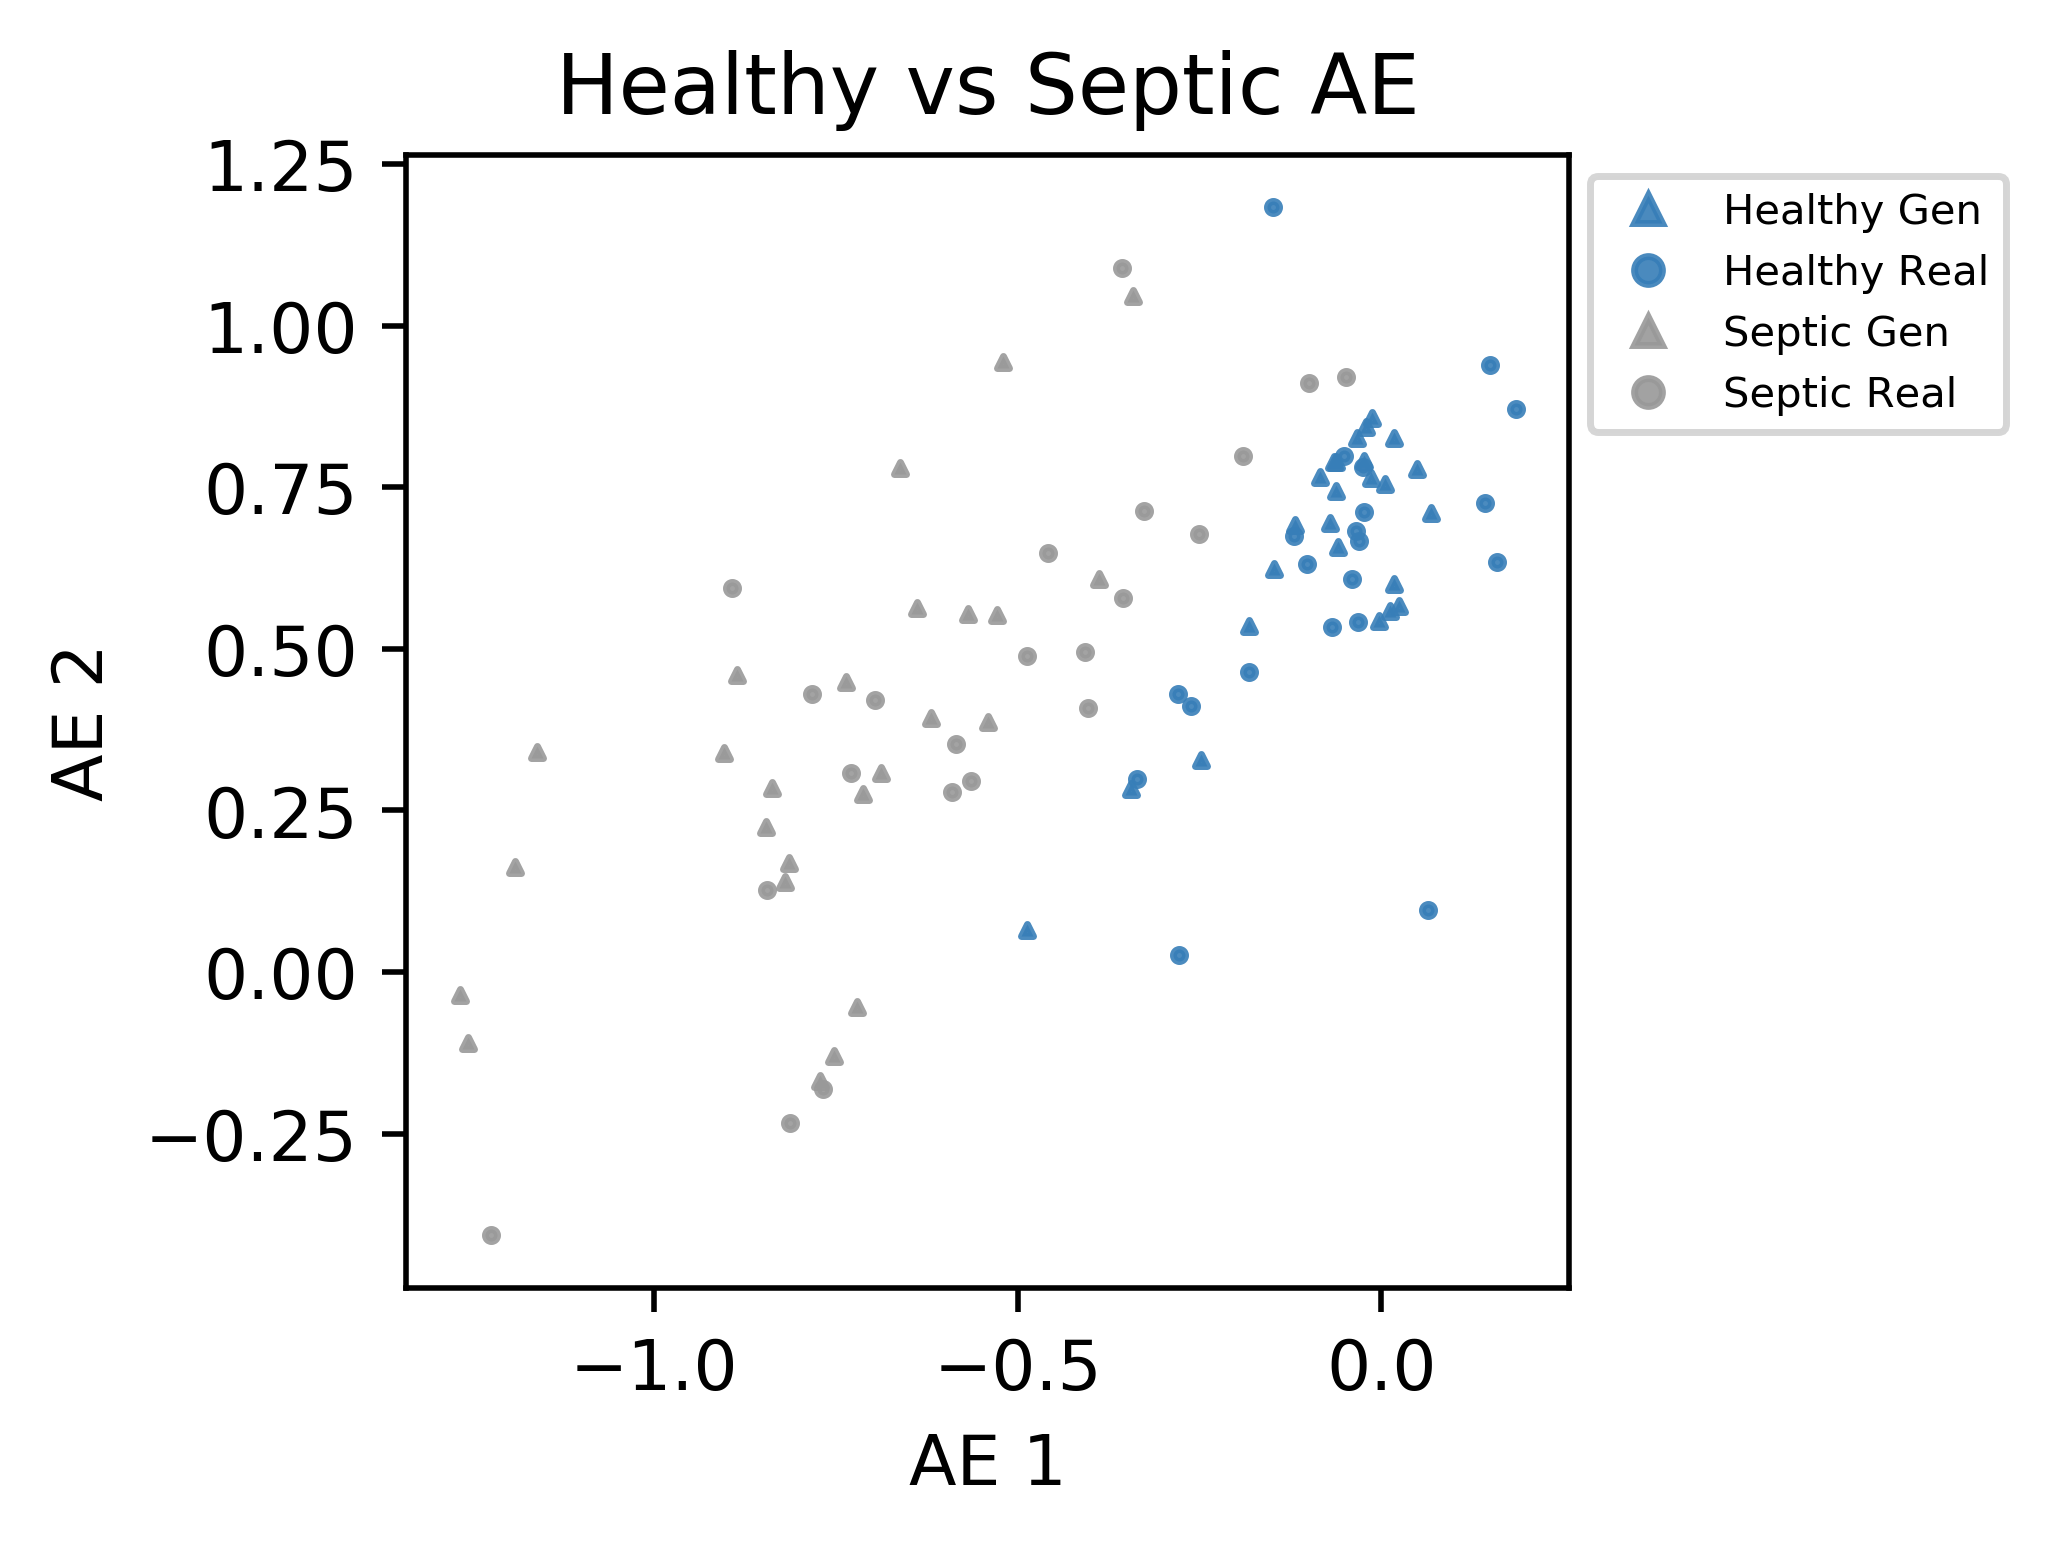

In [28]:
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(AE_lab)
mapping = dict(zip(le.classes_, range(len(le.classes_))))

aeplot = plot_dim_reduction(AE_x, AE_y, labels_encoded, mapping=mapping, sub = sub_list, my_method="AE")
aeplot[0].savefig("healthysep_AE.pdf", format="pdf")

In [93]:
aeplot[0].savefig("healthysep_AE.pdf", format="pdf",bbox_inches='tight')

#### Variational Autoencoder (VAE)

In [29]:
class VAE(nn.Module):
    def __init__(self, encoder_layers, latent_dim, decoder_layers, dropout_prob=0.1):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.encoder_layers = nn.ModuleList()
        for i in range(len(encoder_layers) - 1):
            self.encoder_layers.append(nn.Linear(encoder_layers[i], encoder_layers[i + 1]))
            if i != len(encoder_layers) - 2:   
                self.encoder_layers.append(nn.Tanh())                           
        
        # Latent space layers
        self.fc_mu = nn.Linear(encoder_layers[-1], latent_dim)
        self.fc_logvar = nn.Linear(encoder_layers[-1], latent_dim)

        # Decoder layers
        self.decoder_layers = nn.ModuleList()
        self.decoder_layers.append(nn.Linear(latent_dim, decoder_layers[0]))
        for i in range(len(decoder_layers) - 1):
            self.decoder_layers.append(nn.Linear(decoder_layers[i], decoder_layers[i + 1]))
            if i != len(decoder_layers) - 2:  
                self.decoder_layers.append(nn.Tanh())                           

    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, x):
        for layer in self.decoder_layers:
            x = layer(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    
    MSE = F.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + KLD

class Dataset(torch.utils.data.Dataset):

    'Characterizes a dataset for PyTorch'
    def __init__(self, X_train, y_label):

        self.X_train = X_train
        self.y_labels = y_label

    def __len__(self):
    
        'Denotes the total number of samples'
        return self.X_train.shape[0]

    def __getitem__(self, index):
    
        'Generates one sample of data'
        return self.X_train[index,:], self.y_labels[index]
    
def train_AE(learning_rate, n_epochs, feat_vec, grnd_truth, chk_fname):
    
    input_dim = feat_vec.shape[1]
    latent_dim = 2
    
    print("Num. Features " + str(input_dim))
    
    encoder_neurons = [input_dim, 24, 16, 12, 8]  
    decoder_neurons = [8, 12, 16, 24, input_dim]  

    model = VAE(encoder_neurons, latent_dim, decoder_neurons)
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    data_params = {'batch_size': 64, 'shuffle': True, 'num_workers': 2} #Had to set num_workers to 0 for windows
    
    training_set = Dataset(feat_vec, grnd_truth)
    dataloader = torch.utils.data.DataLoader(training_set, **data_params)
    
    loss_vals = []
    
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    for epoch in range(1, n_epochs+1):

        epoch_losses = 0.0

        for data_batch, data_batch_params in dataloader:

            optimizer.zero_grad()
            y = data_batch_params
            
            x = data_batch.float()
            
            recon_x, mu, logvar = model(x)
            
            loss = vae_loss(recon_x, x, mu, logvar)

            epoch_losses += loss

            loss.backward()
            optimizer.step()

        epoch_losses /= data_params['batch_size']

        tot_loss = epoch_losses.detach().numpy()

        if epoch % 50 == 0:
            print(f"Epoch ({epoch}/{n_epochs}) \t Net Loss:{tot_loss}")
            
        loss_vals.append(tot_loss)
        
    torch.save({
            'epoch': epoch,
            'model_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, chk_fname)
    
    return loss_vals, model, dataloader

def transform_AE(chk_fname, model, dataloader):

    checkpoint = torch.load(chk_fname)
    
    model.load_state_dict(checkpoint['model_dict'])
    
    model.eval()
    
    embed_x = []
    embed_y = []
    embed_label = []

    with torch.no_grad():

        for data_batch, data_batch_params in dataloader:

            data_batch = data_batch.float()

            recon_x, z, logvar = model(data_batch)
            embed_npy = z.detach().numpy()
            
            embed_x.extend(embed_npy[:,0])
            embed_y.extend(embed_npy[:,1])
            
            embed_label.extend(data_batch_params)
            
    embed_x = np.asarray(embed_x)
    embed_y = np.asarray(embed_y)
    
    return (embed_x, embed_y, embed_label)

def plot_loss(n_epochs, loss_vals, title_str):
    
    plt.figure(figsize=(3,1), dpi=300)
    plt.plot(np.arange(n_epochs), loss_vals, linewidth=0.7)
    plt.title(title_str, fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.xlabel("Epochs", fontsize=7)
    plt.ylabel("Total Loss", fontsize=7)
    plt.show()

Num. Features 35
VAE(
  (encoder_layers): ModuleList(
    (0): Linear(in_features=35, out_features=24, bias=True)
    (1): Tanh()
    (2): Linear(in_features=24, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=8, bias=True)
  )
  (fc_mu): Linear(in_features=8, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=8, out_features=2, bias=True)
  (decoder_layers): ModuleList(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=12, bias=True)
    (2): Tanh()
    (3): Linear(in_features=12, out_features=16, bias=True)
    (4): Tanh()
    (5): Linear(in_features=16, out_features=24, bias=True)
    (6): Tanh()
    (7): Linear(in_features=24, out_features=35, bias=True)
  )
)
Epoch (50/500) 	 Net Loss:0.03195232152938843
Epoch (100/500) 	 Net Loss:0.030354229733347893
Epoch (150/500) 	 Net Loss:0.02951269969344139
Epoch (

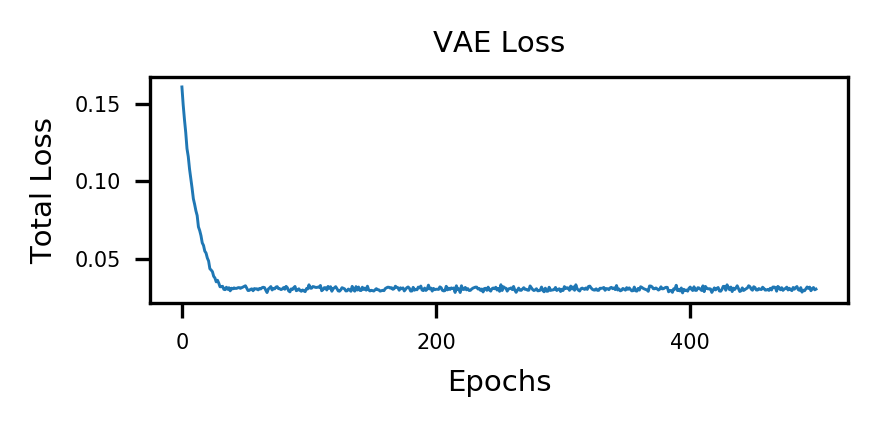

In [30]:
n_epochs = 500

X_std = StandardScaler().fit_transform(X)

(loss_vals, model, dl) = train_AE(1e-3, n_epochs, X_std, y, "TDA_VAE_model_healthy_sepsis.chk")

(AE_x, AE_y, AE_lab) = transform_AE("TDA_VAE_model_healthy_sepsis.chk", model, dl)

plot_loss(n_epochs, loss_vals, "VAE Loss")

(<Figure size 1500x1500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6d0ad6a58>)

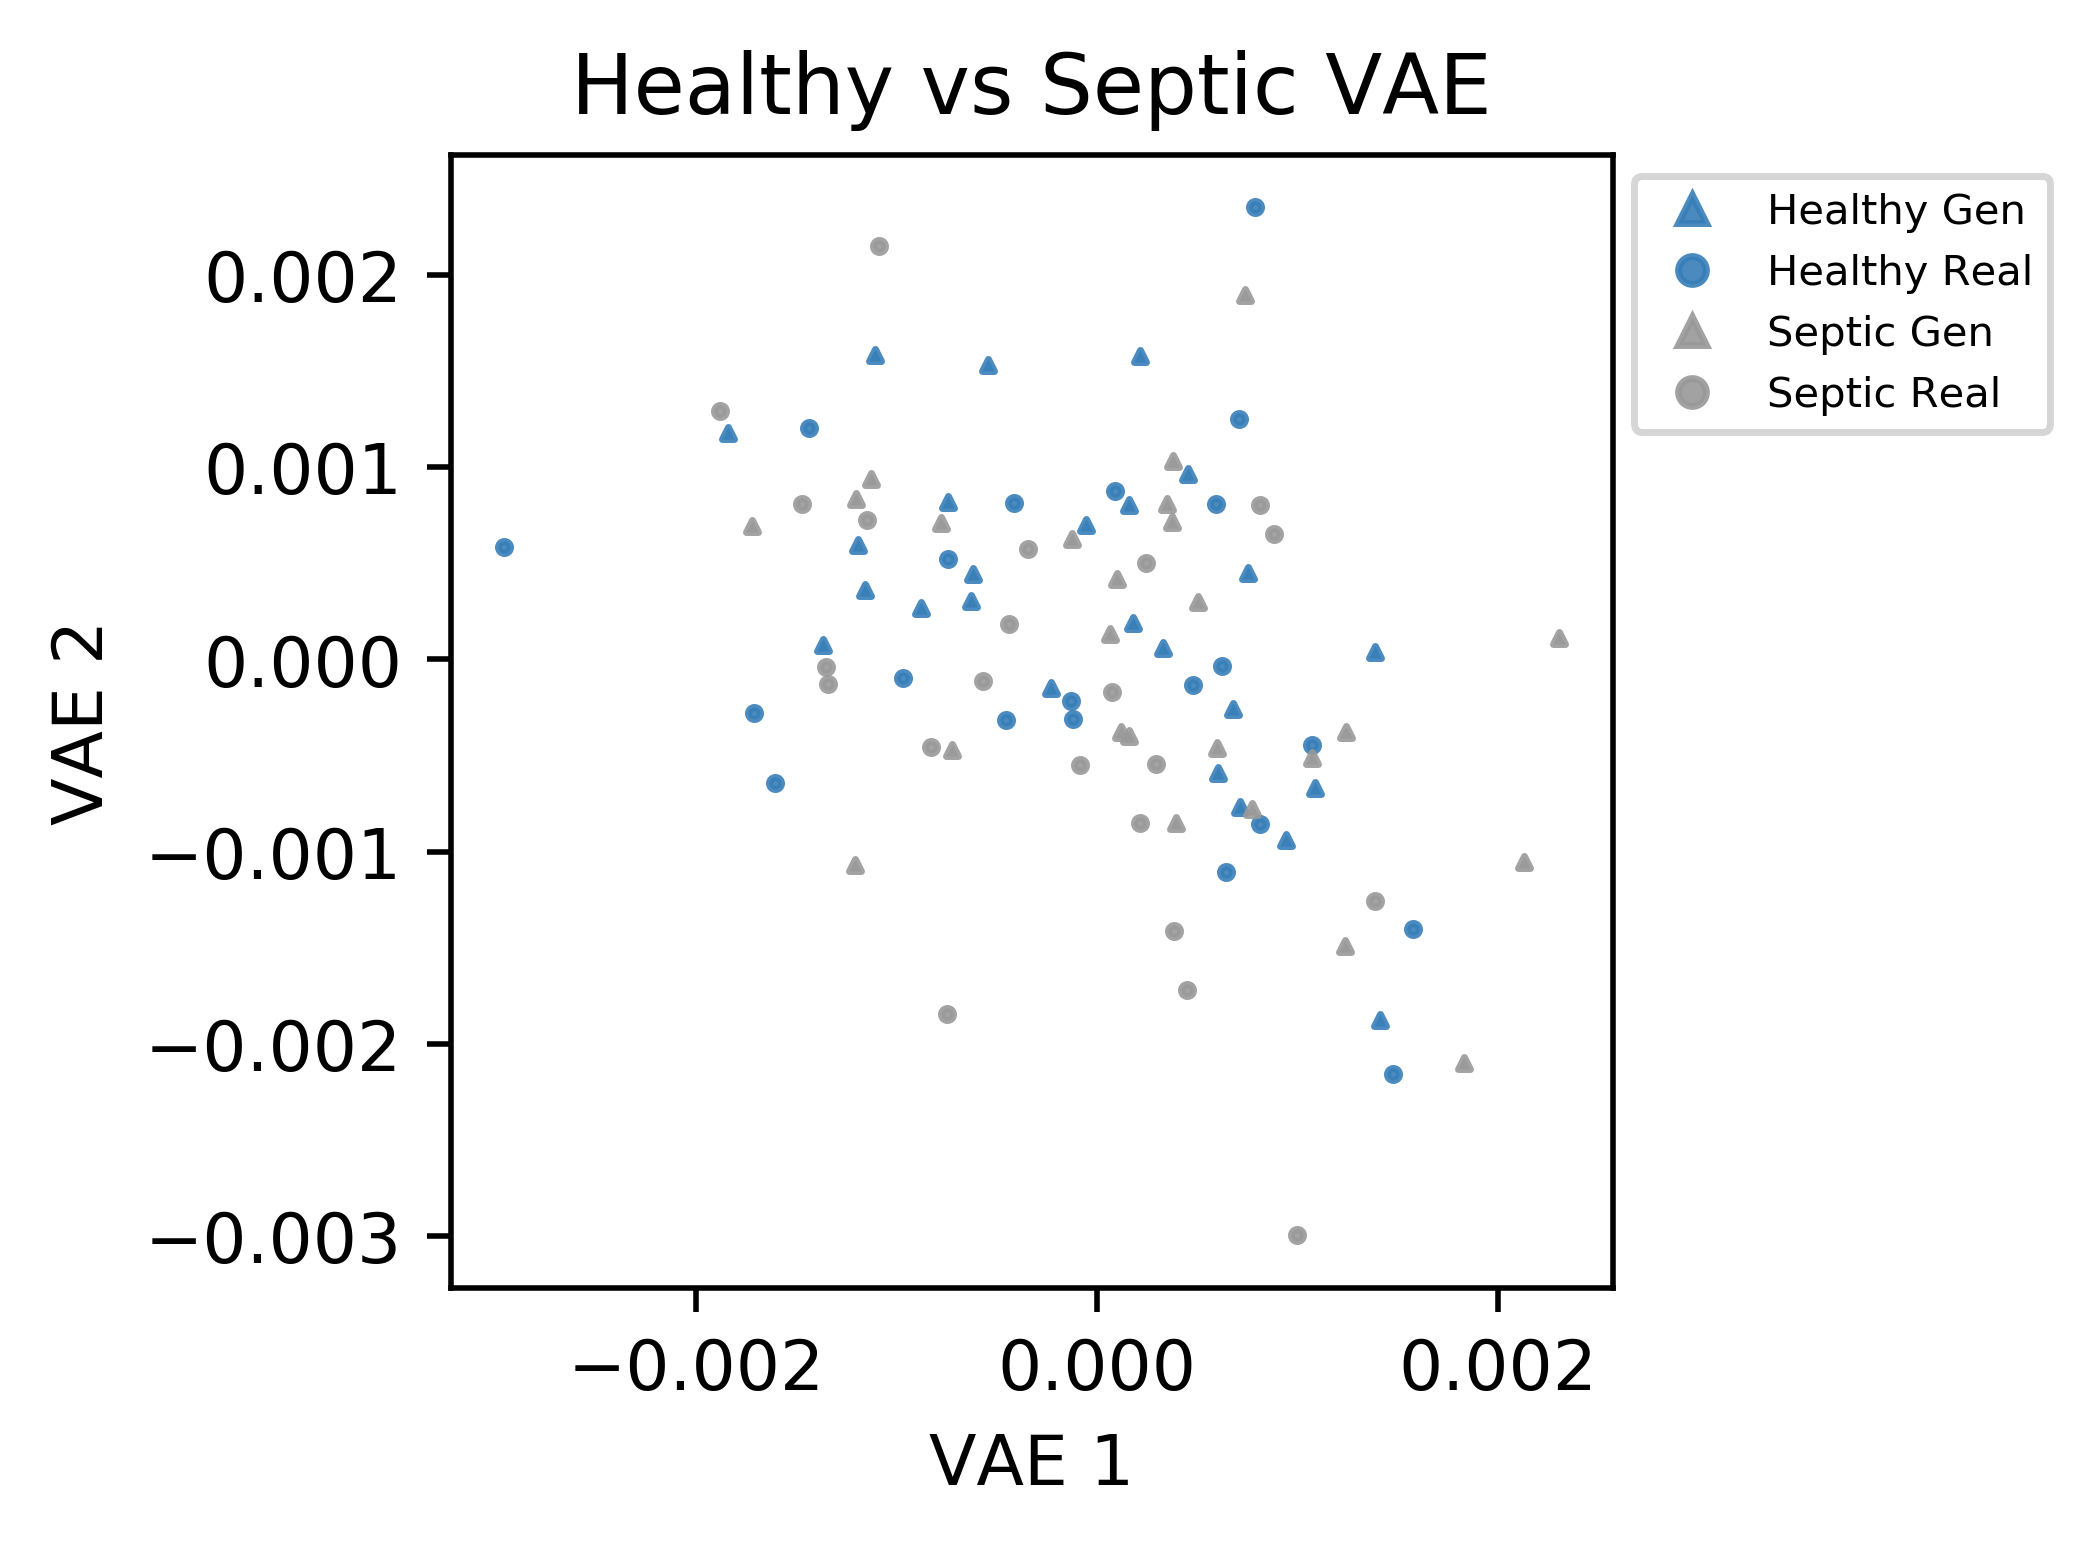

In [31]:
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(AE_lab)
mapping = dict(zip(le.classes_, range(len(le.classes_))))

plot_dim_reduction(AE_x, AE_y, labels_encoded, mapping=mapping, sub = sub_list, my_method="VAE")

#### Manifold Regularized Autoencoder (MRAE)

In [32]:
class ManifoldDataset(torch.utils.data.Dataset):

    'Characterizes a dataset for PyTorch'
    def __init__(self, X_train, y_label, manifold_emb):

        self.X_train = X_train
        self.y_labels = y_label
        self.manifold_emb = manifold_emb

    def __len__(self):
    
        'Denotes the total number of samples'
        return self.X_train.shape[0]

    def __getitem__(self, index):
    
        'Generates one sample of data'
        return self.X_train[index,:], self.y_labels[index], self.manifold_emb[index]
    
def train_manifold_AE(learning_rate, n_epochs, feat_vec, grnd_truth, embedding, chk_fname):
    
    input_dim = feat_vec.shape[1]
    manifold_dim = 2

    enc_arch = [input_dim, 24, 16, 8, 4, manifold_dim]
    dec_arch = [manifold_dim, 4, 8, 16, 24, input_dim]

    encoder = Encoder(enc_arch)
    decoder = Decoder(dec_arch)
    
    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)
    
    criterion = torch.nn.MSELoss()
    mr_criterion = torch.nn.MSELoss()
    
    data_params = {'batch_size': 64, 'shuffle': True, 'num_workers': 2}
    
    training_set = ManifoldDataset(feat_vec, grnd_truth, embedding)
    dataloader = torch.utils.data.DataLoader(training_set, **data_params)
    
    loss_vals = []

    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    for epoch in range(1, n_epochs+1):

        epoch_losses = 0.0
        epoch_rconst_losses = 0.0
        epoch_manifold_reg_losses = 0.0

        for data_batch, data_batch_params, embed_batch in dataloader:

            optimizer.zero_grad()
            y = data_batch_params
            
            data_batch = data_batch.float()
            embed_batch = embed_batch.float()
            
            z = encoder(data_batch)
            output = decoder(z)
            
            loss_reconstruct = criterion(output, data_batch)
            loss_manifold_reg = mr_criterion(z, embed_batch)

            loss = loss_reconstruct + loss_manifold_reg

            epoch_rconst_losses += loss_reconstruct
            epoch_manifold_reg_losses += loss_manifold_reg
            epoch_losses += loss

            loss.backward()
            optimizer.step()

        epoch_rconst_losses /= data_params['batch_size']
        epoch_manifold_reg_losses /= data_params['batch_size']
        epoch_losses /= data_params['batch_size']

        tot_loss = epoch_losses.detach().numpy()
        rconst_loss = epoch_rconst_losses.detach().numpy()
        manifold_reg_loss = epoch_manifold_reg_losses.detach().numpy()

        if epoch % 50 == 0:
            print(f"Epoch ({epoch}/{n_epochs}) \t Net Loss:{tot_loss}")
            
        loss_vals.append(tot_loss)
        
    torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, chk_fname)
    
    return loss_vals, encoder, decoder, dataloader

def transform_MRAE(chk_fname, enc_arch, dec_arch, feat_vec, grnd_truth, embedding):
    
    encoder = Encoder(enc_arch)
    decoder = Decoder(dec_arch)

    checkpoint = torch.load(chk_fname)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])

    data_params = {'batch_size': 64, 'shuffle': False, 'num_workers': 2}
    training_set = ManifoldDataset(feat_vec, grnd_truth, embedding)
    dataloader = torch.utils.data.DataLoader(training_set, **data_params)
    
    encoder.eval()
    
    embed_x = []
    embed_y = []
    embed_label = []

    with torch.no_grad():

        for data_batch, data_batch_params, embed_batch in dataloader:

            data_batch = data_batch.float()
            embed_batch = embed_batch.float()

            z = encoder(data_batch)

            embed_npy = z.detach().numpy()

            embed_x.extend(embed_npy[:,0])
            embed_y.extend(embed_npy[:,1])
            
            embed_label.extend(data_batch_params)
            
    embed_x = np.asarray(embed_x)
    embed_y = np.asarray(embed_y)
    
    return (embed_x, embed_y, embed_label)

Epoch (50/500) 	 Net Loss:0.011123443022370338
Epoch (100/500) 	 Net Loss:0.008462847210466862
Epoch (150/500) 	 Net Loss:0.007423712406307459
Epoch (200/500) 	 Net Loss:0.0070715718902647495
Epoch (250/500) 	 Net Loss:0.006046870723366737
Epoch (300/500) 	 Net Loss:0.005814571399241686
Epoch (350/500) 	 Net Loss:0.006816527806222439
Epoch (400/500) 	 Net Loss:0.0072008478455245495
Epoch (450/500) 	 Net Loss:0.006081488914787769
Epoch (500/500) 	 Net Loss:0.004621667787432671


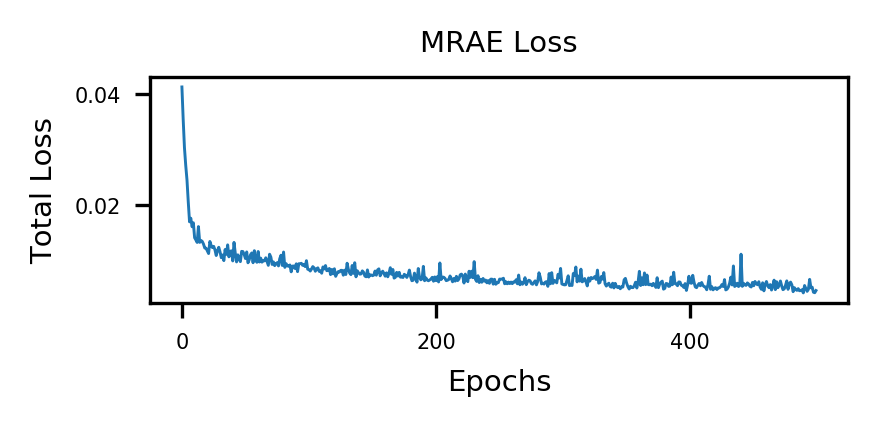

In [33]:
n_epochs = 500

X_std = StandardScaler().fit_transform(X)

(loss_vals, enc, dec, dl) = train_manifold_AE(5e-3, n_epochs, X_std, y, emb_phate, "TDA_MRAE_model_healthy_sepsis.chk")

(AE_x, AE_y, AE_lab) = transform_MRAE("TDA_MRAE_model_healthy_sepsis.chk", enc_arch, dec_arch, X_std, y, emb_phate)

plot_loss(n_epochs, loss_vals, "MRAE Loss")

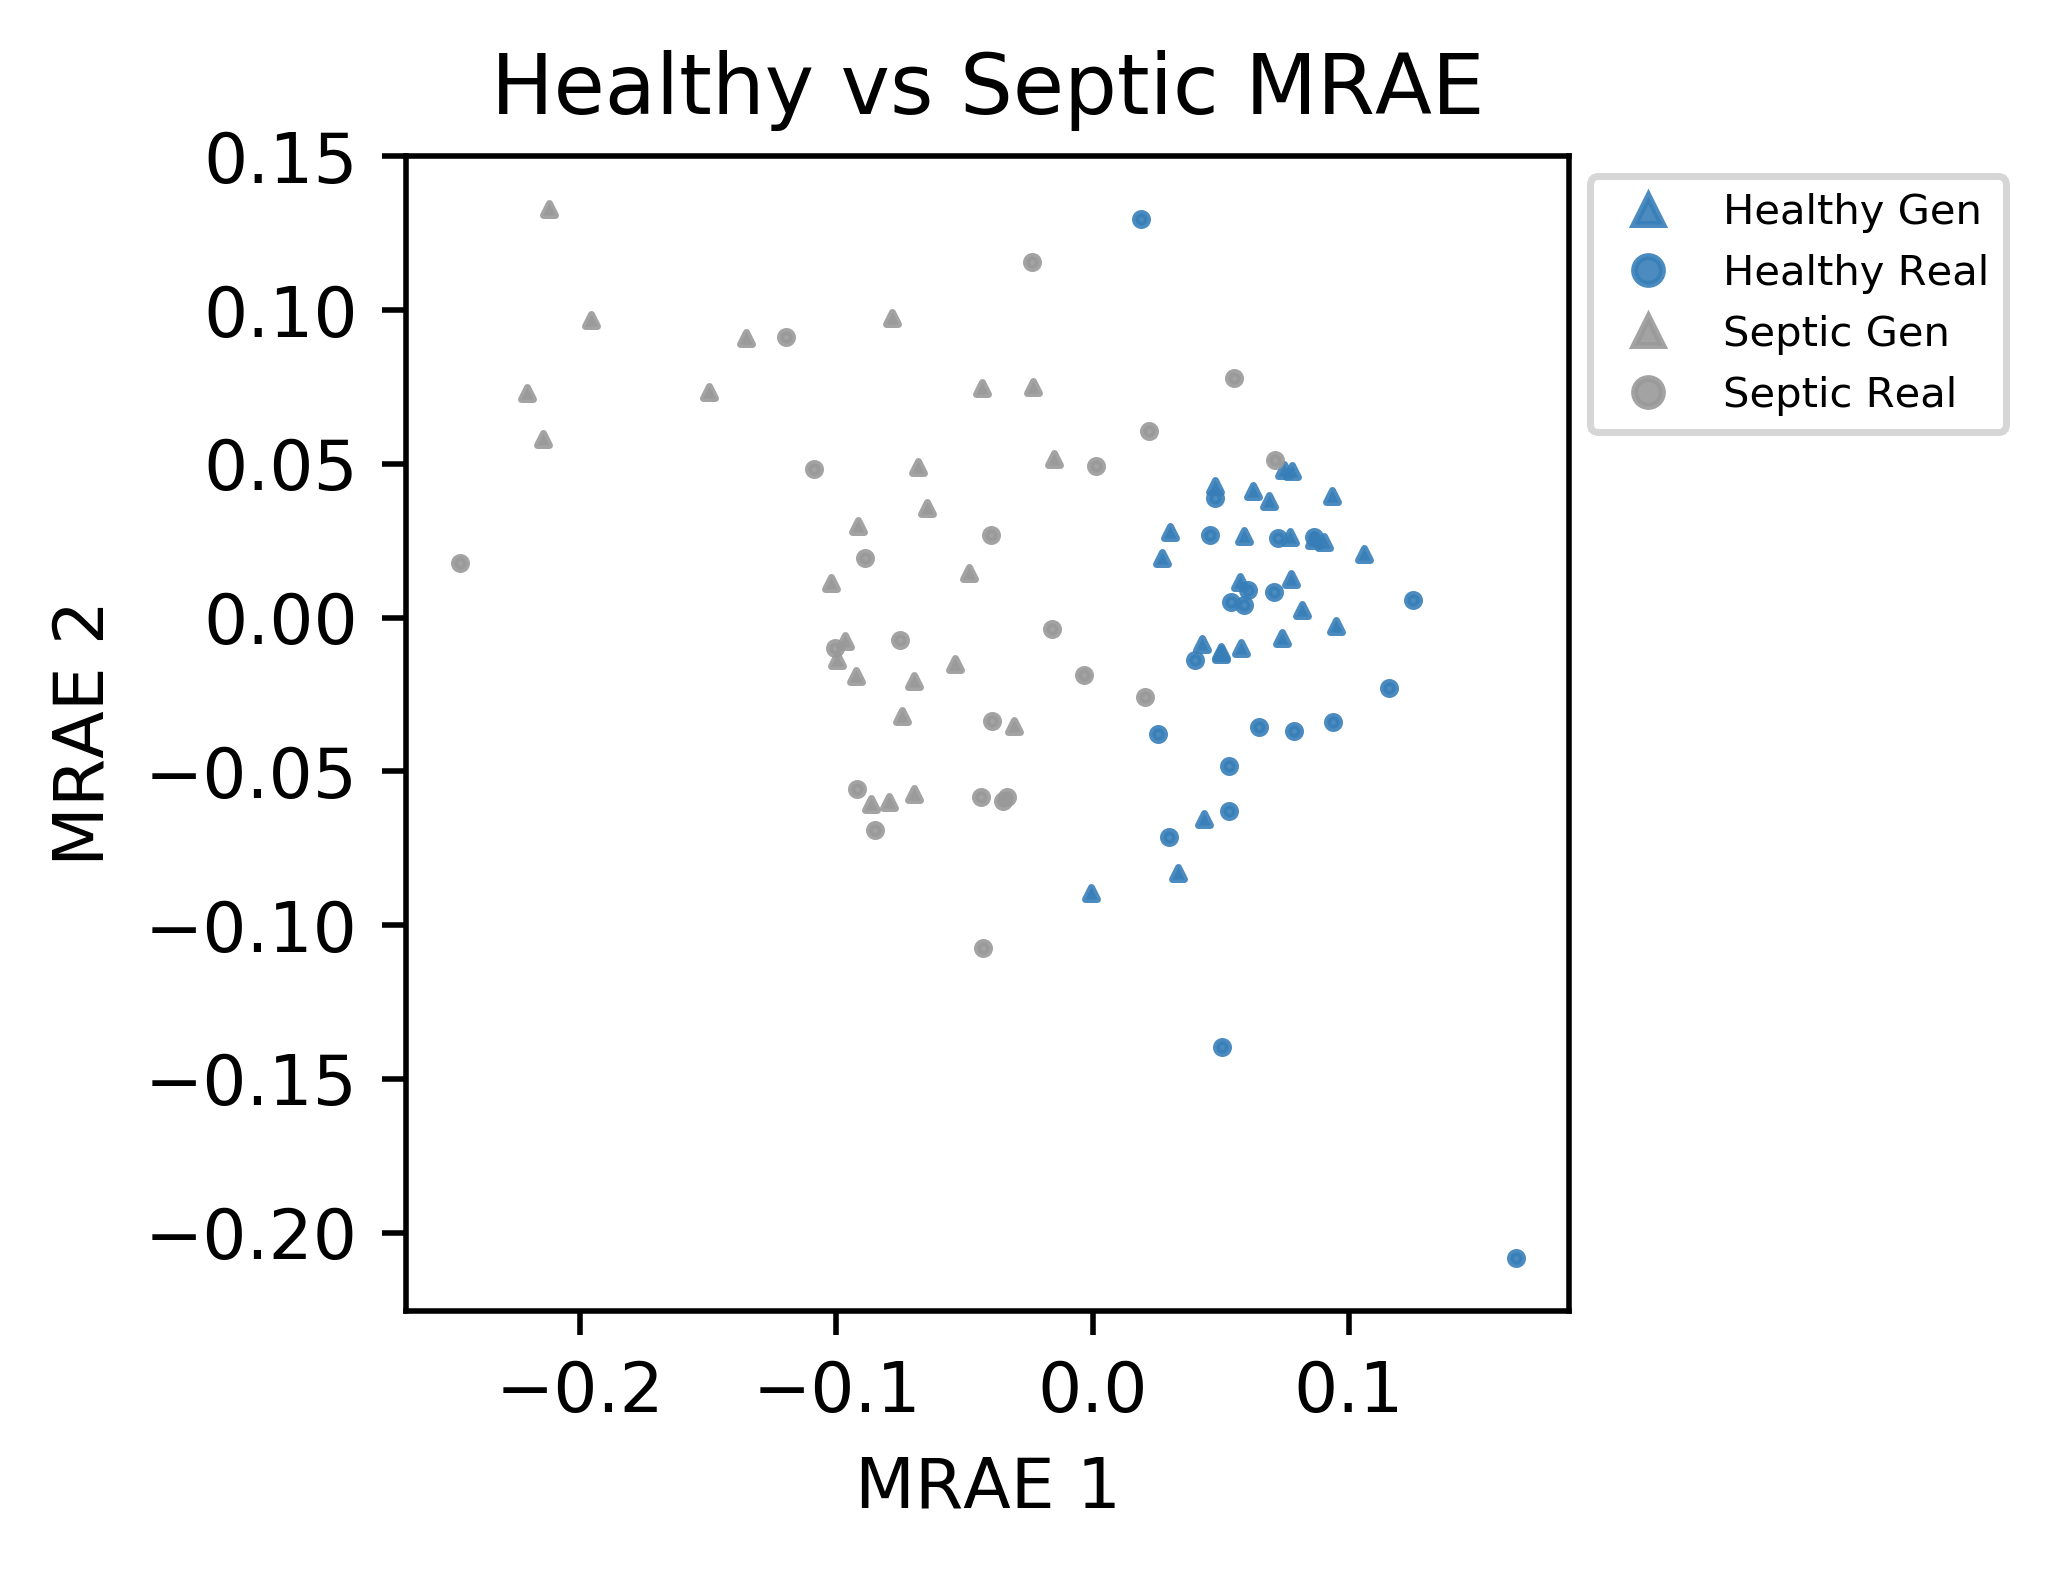

In [88]:
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(AE_lab)

mapping = dict(zip(le.classes_, range(len(le.classes_))))

mrae_plot = plot_dim_reduction(AE_x, AE_y, labels_encoded, mapping=mapping, sub = sub_list, my_method="MRAE")
mrae_plot[0].savefig("healthysep_MRAE_noshapes.pdf", format="pdf", bbox_inches='tight')

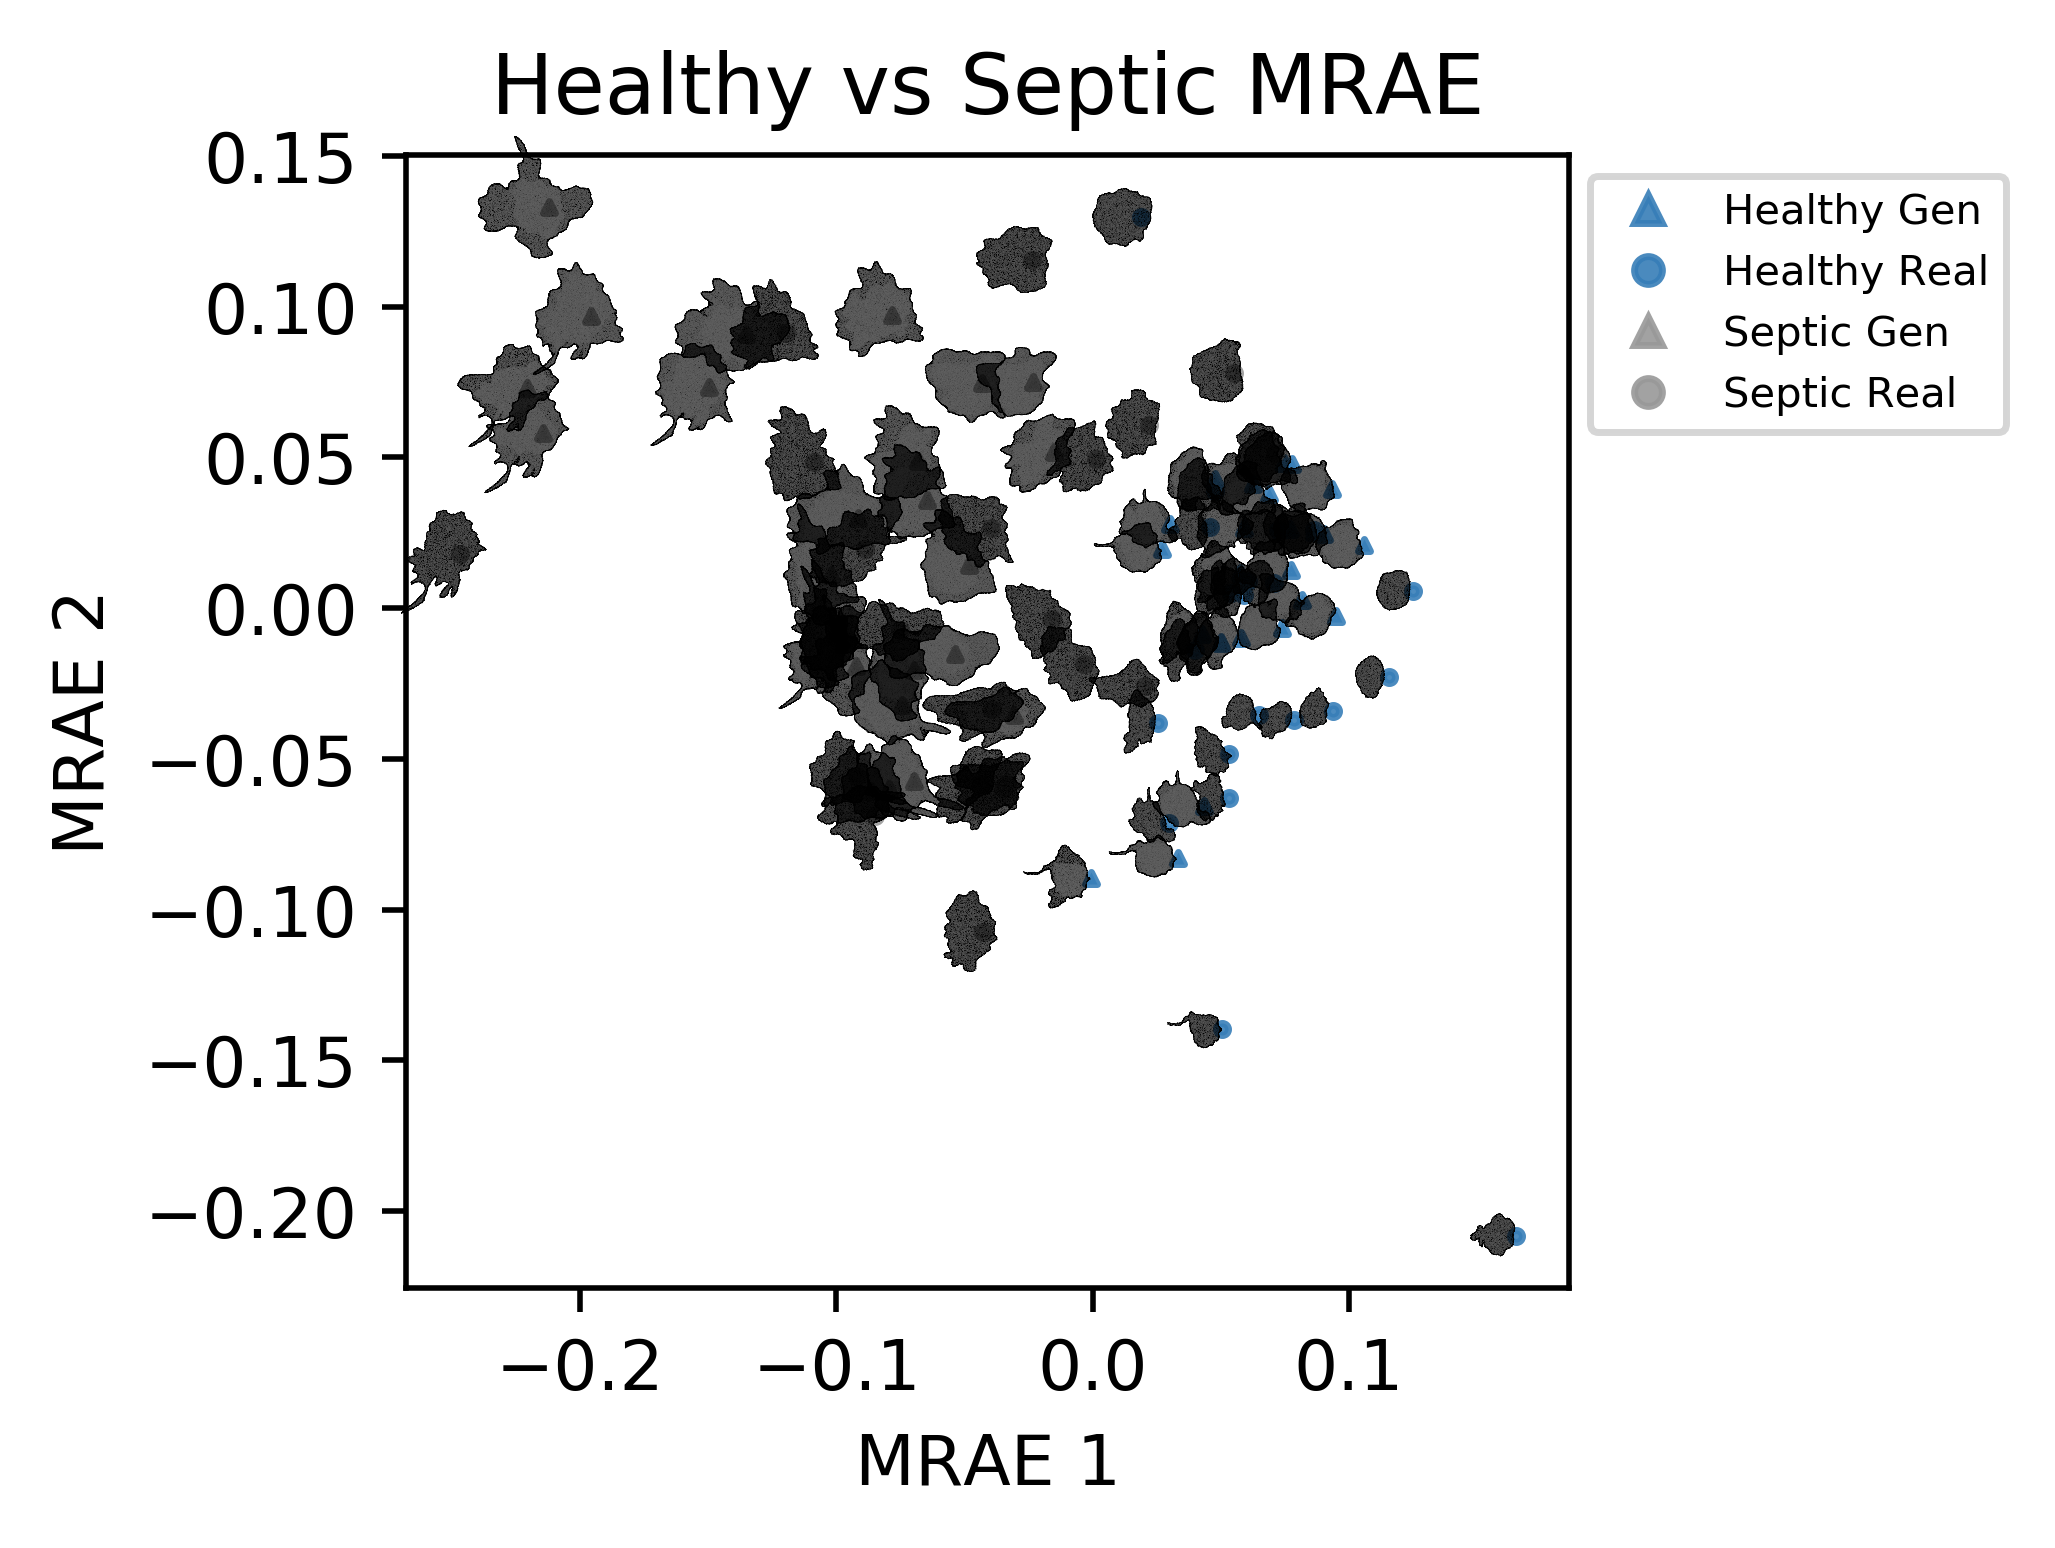

In [39]:
#Plot with all neutrophils
def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

num_neut = np.shape(df)[0]
paths = ['MRAE_imgs/' + df['stim_stiff'][i]+'/'+df['CellID_EXP'][i] + '.png' for i in range(num_neut)]
fig,ax = plot_dim_reduction(AE_x, AE_y, labels_encoded, mapping=mapping, sub = sub_list, my_method="MRAE")
for i in range(num_neut):
    ab = AnnotationBbox(getImage(paths[i], zoom = 0.05), (AE_x[i], AE_y[i]), frameon=False)
    ax.add_artist(ab)
fig.savefig("healthysep_MRAE_shapes.pdf", format="pdf", bbox_inches='tight')

In [40]:
torch.load("TDA_MRAE_model_healthy_sepsis.chk")['encoder_state_dict']

OrderedDict([('encoder.0.weight',
              tensor([[ 1.5802e-01,  7.6631e-02, -4.9445e-02, -4.2793e-02,  5.6497e-02,
                        7.4351e-02, -1.6323e-02,  2.0101e-01,  4.7836e-02, -1.7909e-01,
                        7.3135e-02,  1.4882e-01,  6.3970e-02,  1.1151e-01, -1.3745e-01,
                        9.5252e-02,  3.2851e-01, -8.2400e-02, -1.1989e-01,  2.0275e-01,
                       -7.2057e-02,  3.6397e-02,  2.8706e-01,  9.9099e-02,  1.8439e-02,
                       -2.4134e-01,  1.6555e-01, -7.6670e-02,  6.3883e-03, -5.2259e-03,
                       -5.3883e-02, -5.3671e-02,  5.4681e-02, -1.5048e-01, -8.4152e-02],
                      [-5.6777e-02, -3.1166e-02, -6.6820e-02,  1.4008e-03, -3.8914e-02,
                       -1.3032e-01,  6.9165e-02, -1.5430e-01, -4.5496e-02,  8.3422e-02,
                       -3.8414e-03, -2.7652e-01,  3.4312e-02, -1.3029e-01, -1.0668e-02,
                        1.1654e-02,  1.9277e-01, -1.4915e-01, -1.1987e-03, -5.9524e-0

In [41]:
weight0 = torch.load("TDA_MRAE_model_healthy_sepsis.chk")['encoder_state_dict']['encoder.0.weight']
weight1 = torch.load("TDA_MRAE_model_healthy_sepsis.chk")['encoder_state_dict']['encoder.3.weight']
weight2 = torch.load("TDA_MRAE_model_healthy_sepsis.chk")['encoder_state_dict']['encoder.6.weight']
weight3 = torch.load("TDA_MRAE_model_healthy_sepsis.chk")['encoder_state_dict']['encoder.9.weight']
weight4 = torch.load("TDA_MRAE_model_healthy_sepsis.chk")['encoder_state_dict']['encoder.12.weight']

In [42]:
weight_tol = torch.matmul(weight4, weight3)
weight_tol = torch.matmul(weight_tol, weight2)
weight_tol = torch.matmul(weight_tol, weight1)
weight_tol = torch.matmul(weight_tol, weight0)
weight_tol

tensor([[-0.0469, -0.0788, -0.0372, -0.0736, -0.0420, -0.0628,  0.0371, -0.0596,
         -0.0463, -0.0168, -0.0382, -0.0173,  0.0024, -0.0375, -0.0260, -0.0607,
         -0.0354, -0.0321,  0.0063, -0.0212,  0.0155, -0.0493, -0.0199,  0.0535,
         -0.0164, -0.0285, -0.0114,  0.0754, -0.0053, -0.0104,  0.0283,  0.0541,
          0.0031, -0.0451, -0.0012],
        [ 0.0414,  0.0406,  0.0358,  0.0572,  0.0179,  0.0543, -0.0554,  0.0403,
          0.0051, -0.0013, -0.0088,  0.0044, -0.0228,  0.0265,  0.0270,  0.0552,
         -0.0051,  0.0441,  0.0125, -0.0064, -0.0278,  0.0333, -0.0212, -0.0484,
          0.0335,  0.0602, -0.0009, -0.0102,  0.0302, -0.0017, -0.0159, -0.0271,
         -0.0077,  0.0212, -0.0234]])

In [43]:
feat_importance = pd.DataFrame(zip(feats, weight_tol[0]), columns=["feats", "MRAE 1"])
feat_importance.sort_values(['MRAE 1'], ascending=False)

,feats,MRAE 1
27,shape_solidity1,tensor(0.0754)
31,shape_circularity1,tensor(0.0541)
23,bdy_max_curvature1,tensor(0.0535)
6,ellipse_eccentricity1,tensor(0.0371)
30,shape_convexity1,tensor(0.0283)
20,bdy_std_curvature1,tensor(0.0155)
18,eroded_area1,tensor(0.0063)
32,rect_orient1,tensor(0.0031)
12,ellipse_var1,tensor(0.0024)
34,rect_ferret_min1,tensor(-0.0012)


In [44]:
feat_importance = pd.DataFrame(zip(feats, weight_tol[1]), columns=["feats", "MRAE 2"])
feat_importance.sort_values(['MRAE 2'], ascending=False)

,feats,MRAE 2
25,shape_extent1,tensor(0.0602)
3,perimeter1,tensor(0.0572)
15,circle_area1,tensor(0.0552)
5,poly_area1,tensor(0.0543)
17,eroded_perim1,tensor(0.0441)
0,area1,tensor(0.0414)
1,perim_1sqrt21,tensor(0.0406)
7,ellipse_major_ax1,tensor(0.0403)
2,equiv_diameter1,tensor(0.0358)
24,bdy_min_curvature1,tensor(0.0335)


In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

In [53]:
mrae_xy = np.column_stack((AE_x, AE_y))
mrae_xy

array([[ 0.0479617 ,  0.03883447],
       [ 0.04602439,  0.02686254],
       [ 0.03001667, -0.07127117],
       [ 0.12507054,  0.00575449],
       [ 0.0707669 ,  0.00836822],
       [ 0.06057511,  0.00901292],
       [ 0.03992392, -0.01376875],
       [ 0.11586036, -0.02284292],
       [ 0.05390814,  0.00513904],
       [ 0.02556693, -0.03798194],
       [ 0.0940396 , -0.03411903],
       [ 0.08641602,  0.02604045],
       [ 0.05313857, -0.04841201],
       [ 0.07248402,  0.02578035],
       [ 0.05053499, -0.13951495],
       [ 0.0788025 , -0.03698534],
       [ 0.05901916,  0.00418685],
       [ 0.01904364,  0.12977916],
       [ 0.16526665, -0.20820397],
       [ 0.06492837, -0.0355101 ],
       [ 0.05322263, -0.06287548],
       [ 0.08647941,  0.02534034],
       [ 0.10616419,  0.02080106],
       [ 0.09330241,  0.03948382],
       [ 0.05005643, -0.01126834],
       [ 0.03023499,  0.02792379],
       [ 0.04334686, -0.06558131],
       [ 0.04997735, -0.01170741],
       [ 0.07411236,

In [54]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 500,
   "random_state": 42,
   }

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(mrae_xy)
    sse.append(kmeans.inertia_)

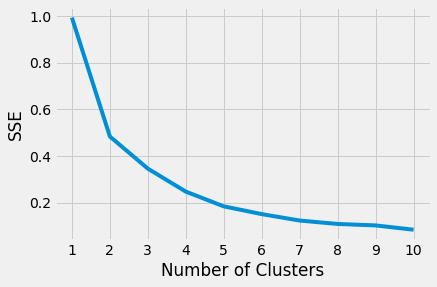

In [55]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

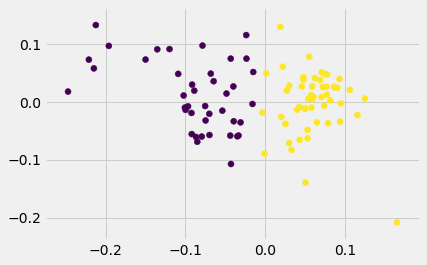

In [58]:
#two clusters
kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
kmeans.fit(mrae_xy)
label = kmeans.fit_predict(mrae_xy)
plt.scatter(AE_x, AE_y, c = label)
plt.show()

In [59]:
label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int32)

In [65]:
mapping2 = {'Healthy_Real_N':1, 'Healthy_Gen_N':1, 'Septic_Real_N':0, 'Septic_Gen_N':0}
true_lab = [mapping2[lab] for lab in AE_lab]
confusion_matrix(true_lab, label)

array([[41,  6],
       [ 0, 46]])

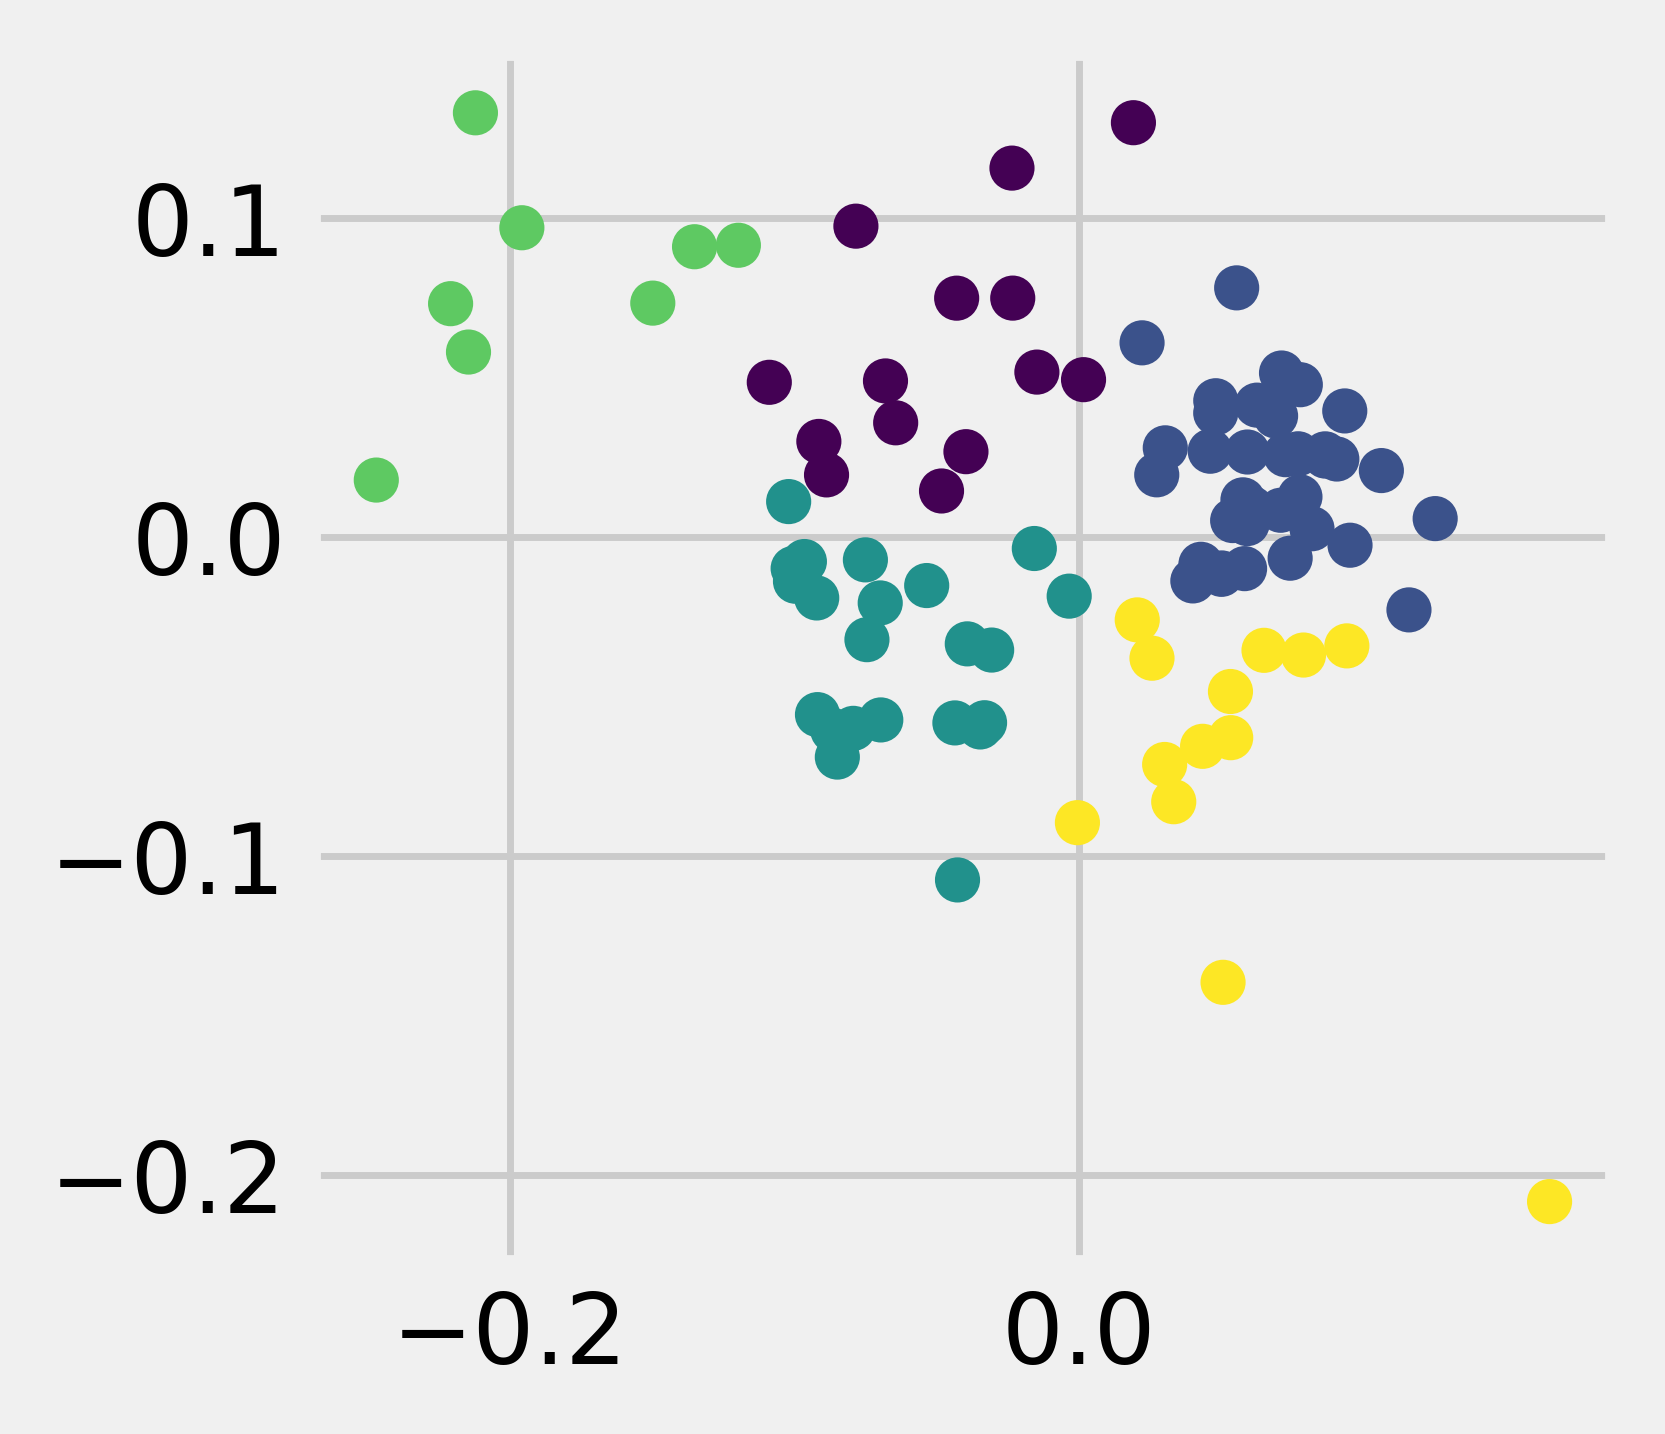

In [76]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(mrae_xy)
label5 = kmeans.fit_predict(mrae_xy)
plt.figure(figsize=(3,3), dpi=500)
plt.scatter(AE_x, AE_y, c = label5)
plt.show()

In [70]:
kmeans.cluster_centers_

array([[-0.04805701,  0.05834793],
       [ 0.06709581,  0.01965261],
       [-0.06458887, -0.03598179],
       [-0.18690734,  0.07927071],
       [ 0.05475552, -0.07222038]], dtype=float32)

In [87]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [89]:
df['MRAE1']=AE_x
df['MRAE2']=AE_y
df['true_lab']=true_lab
df['label_2']=label
df['label_5']=label5
df.head()

,index,cid,area1,perim_1sqrt21,equiv_diameter1,perimeter1,poly_perim1,poly_area1,ellipse_centroid_x1,ellipse_centroid_y1,...,origin,CellID_EXP,fullfilepath,witheld,class_label,MRAE1,MRAE2,true_lab,label_2,label_5
0,0,1,151.9616,54.588594,13.909835,53.546900,53.868652,153.0240,826.367588,829.056267,...,Real,LPS_1-5kPa_2020-07-01_xy01_A,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.047962,0.038834,1,1,1
1,1,2,134.8352,53.004675,13.102576,52.448042,53.099762,135.6032,826.561800,827.330169,...,Real,LPS_1-5kPa_2020-07-01_xy03_A,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.046024,0.026863,1,1,1
2,2,3,124.2112,58.739175,12.575795,57.392160,57.929867,125.5040,827.111913,830.122424,...,Real,LPS_1-5kPa_2020-07-01_xy03_B,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.030017,-0.071271,1,1,4
3,3,4,104.0384,38.652918,11.509379,37.953263,38.283231,104.9216,828.660187,828.479577,...,Real,LPS_1-5kPa_2020-07-01_xy07_A,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.125071,0.005754,1,1,1
4,4,5,125.0816,49.319965,12.619780,48.115467,48.343494,126.1696,829.403602,827.704257,...,Real,LPS_1-5kPa_2020-07-01_xy08_B,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.070767,0.008368,1,1,1


In [92]:
df.to_csv('healthy_sep_everything.csv')

# T Tests

In [99]:
from scipy.stats import ttest_ind

In [15]:
df_h = df[(df['stim_stiff']=='Healthy')]
df_s = df[(df['stim_stiff']=='Septic')]
df_hr = df[(df['origin']=='Real') & (df['stim_stiff']=='Healthy')]
df_hg = df[(df['origin']=='Gen') & (df['stim_stiff']=='Healthy')]
df_sr = df[(df['origin']=='Real') & (df['stim_stiff']=='Septic')]
df_sg = df[(df['origin']=='Gen') & (df['stim_stiff']=='Septic')]

In [122]:
ttest_df = pd.DataFrame(columns = ['Group1', 'Group2', 'feature', 'Tstat', 'pValue'])

for feat in feats:
    tstat, pval = ttest_ind(df_h[feat], df_s[feat])
    ttest_df = ttest_df.append({'Group1': 'HealthyAll', 'Group2':'SepticAll', 'feature':feat, 'Tstat': tstat,
                               'pValue': pval}, ignore_index=True)
    tstat, pval = ttest_ind(df_hr[feat], df_sr[feat])
    ttest_df = ttest_df.append({'Group1': 'HealthyReal', 'Group2':'SepticReal', 'feature':feat, 'Tstat': tstat,
                               'pValue': pval}, ignore_index=True)
    tstat, pval = ttest_ind(df_hr[feat], df_hg[feat])
    ttest_df = ttest_df.append({'Group1': 'HealthyReal', 'Group2':'HealthyGen', 'feature':feat, 'Tstat': tstat,
                               'pValue': pval}, ignore_index=True)
    tstat, pval = ttest_ind(df_sr[feat], df_sg[feat])
    ttest_df = ttest_df.append({'Group1': 'SepticReal', 'Group2':'SepticGen', 'feature':feat, 'Tstat': tstat,
                               'pValue': pval}, ignore_index=True)

In [123]:
ttest_df.to_csv('ttest_take2.csv')

In [115]:
df_c = df
df_c[feats] = X_std

dfc_hr = df[(df_c['origin']=='Real') & (df_c['stim_stiff']=='Healthy')]
dfc_hg = df[(df_c['origin']=='Gen') & (df_c['stim_stiff']=='Healthy')]
dfc_sr = df[(df_c['origin']=='Real') & (df_c['stim_stiff']=='Septic')]
dfc_sg = df[(df_c['origin']=='Gen') & (df_c['stim_stiff']=='Septic')]

In [116]:
ttestc_df = pd.DataFrame(columns = ['Group1', 'Group2', 'feature', 'Tstat', 'pValue'])

for feat in feats:
    tstat, pval = ttest_ind(dfc_hr[feat], dfc_sr[feat])
    ttestc_df = ttestc_df.append({'Group1': 'HealthyReal', 'Group2':'SepticReal', 'feature':feat, 'Tstat': tstat,
                               'pValue': pval}, ignore_index=True)
    tstat, pval = ttest_ind(dfc_hr[feat], dfc_sg[feat])
    ttestc_df = ttestc_df.append({'Group1': 'HealthyReal', 'Group2':'HealthyGen', 'feature':feat, 'Tstat': tstat,
                               'pValue': pval}, ignore_index=True)
    tstat, pval = ttest_ind(dfc_sr[feat], dfc_sg[feat])
    ttestc_df = ttestc_df.append({'Group1': 'SepticReal', 'Group2':'SepticGen', 'feature':feat, 'Tstat': tstat,
                               'pValue': pval}, ignore_index=True)

In [117]:
ttestc_df.to_csv('ttest_centered_take1.csv')

# Box plots

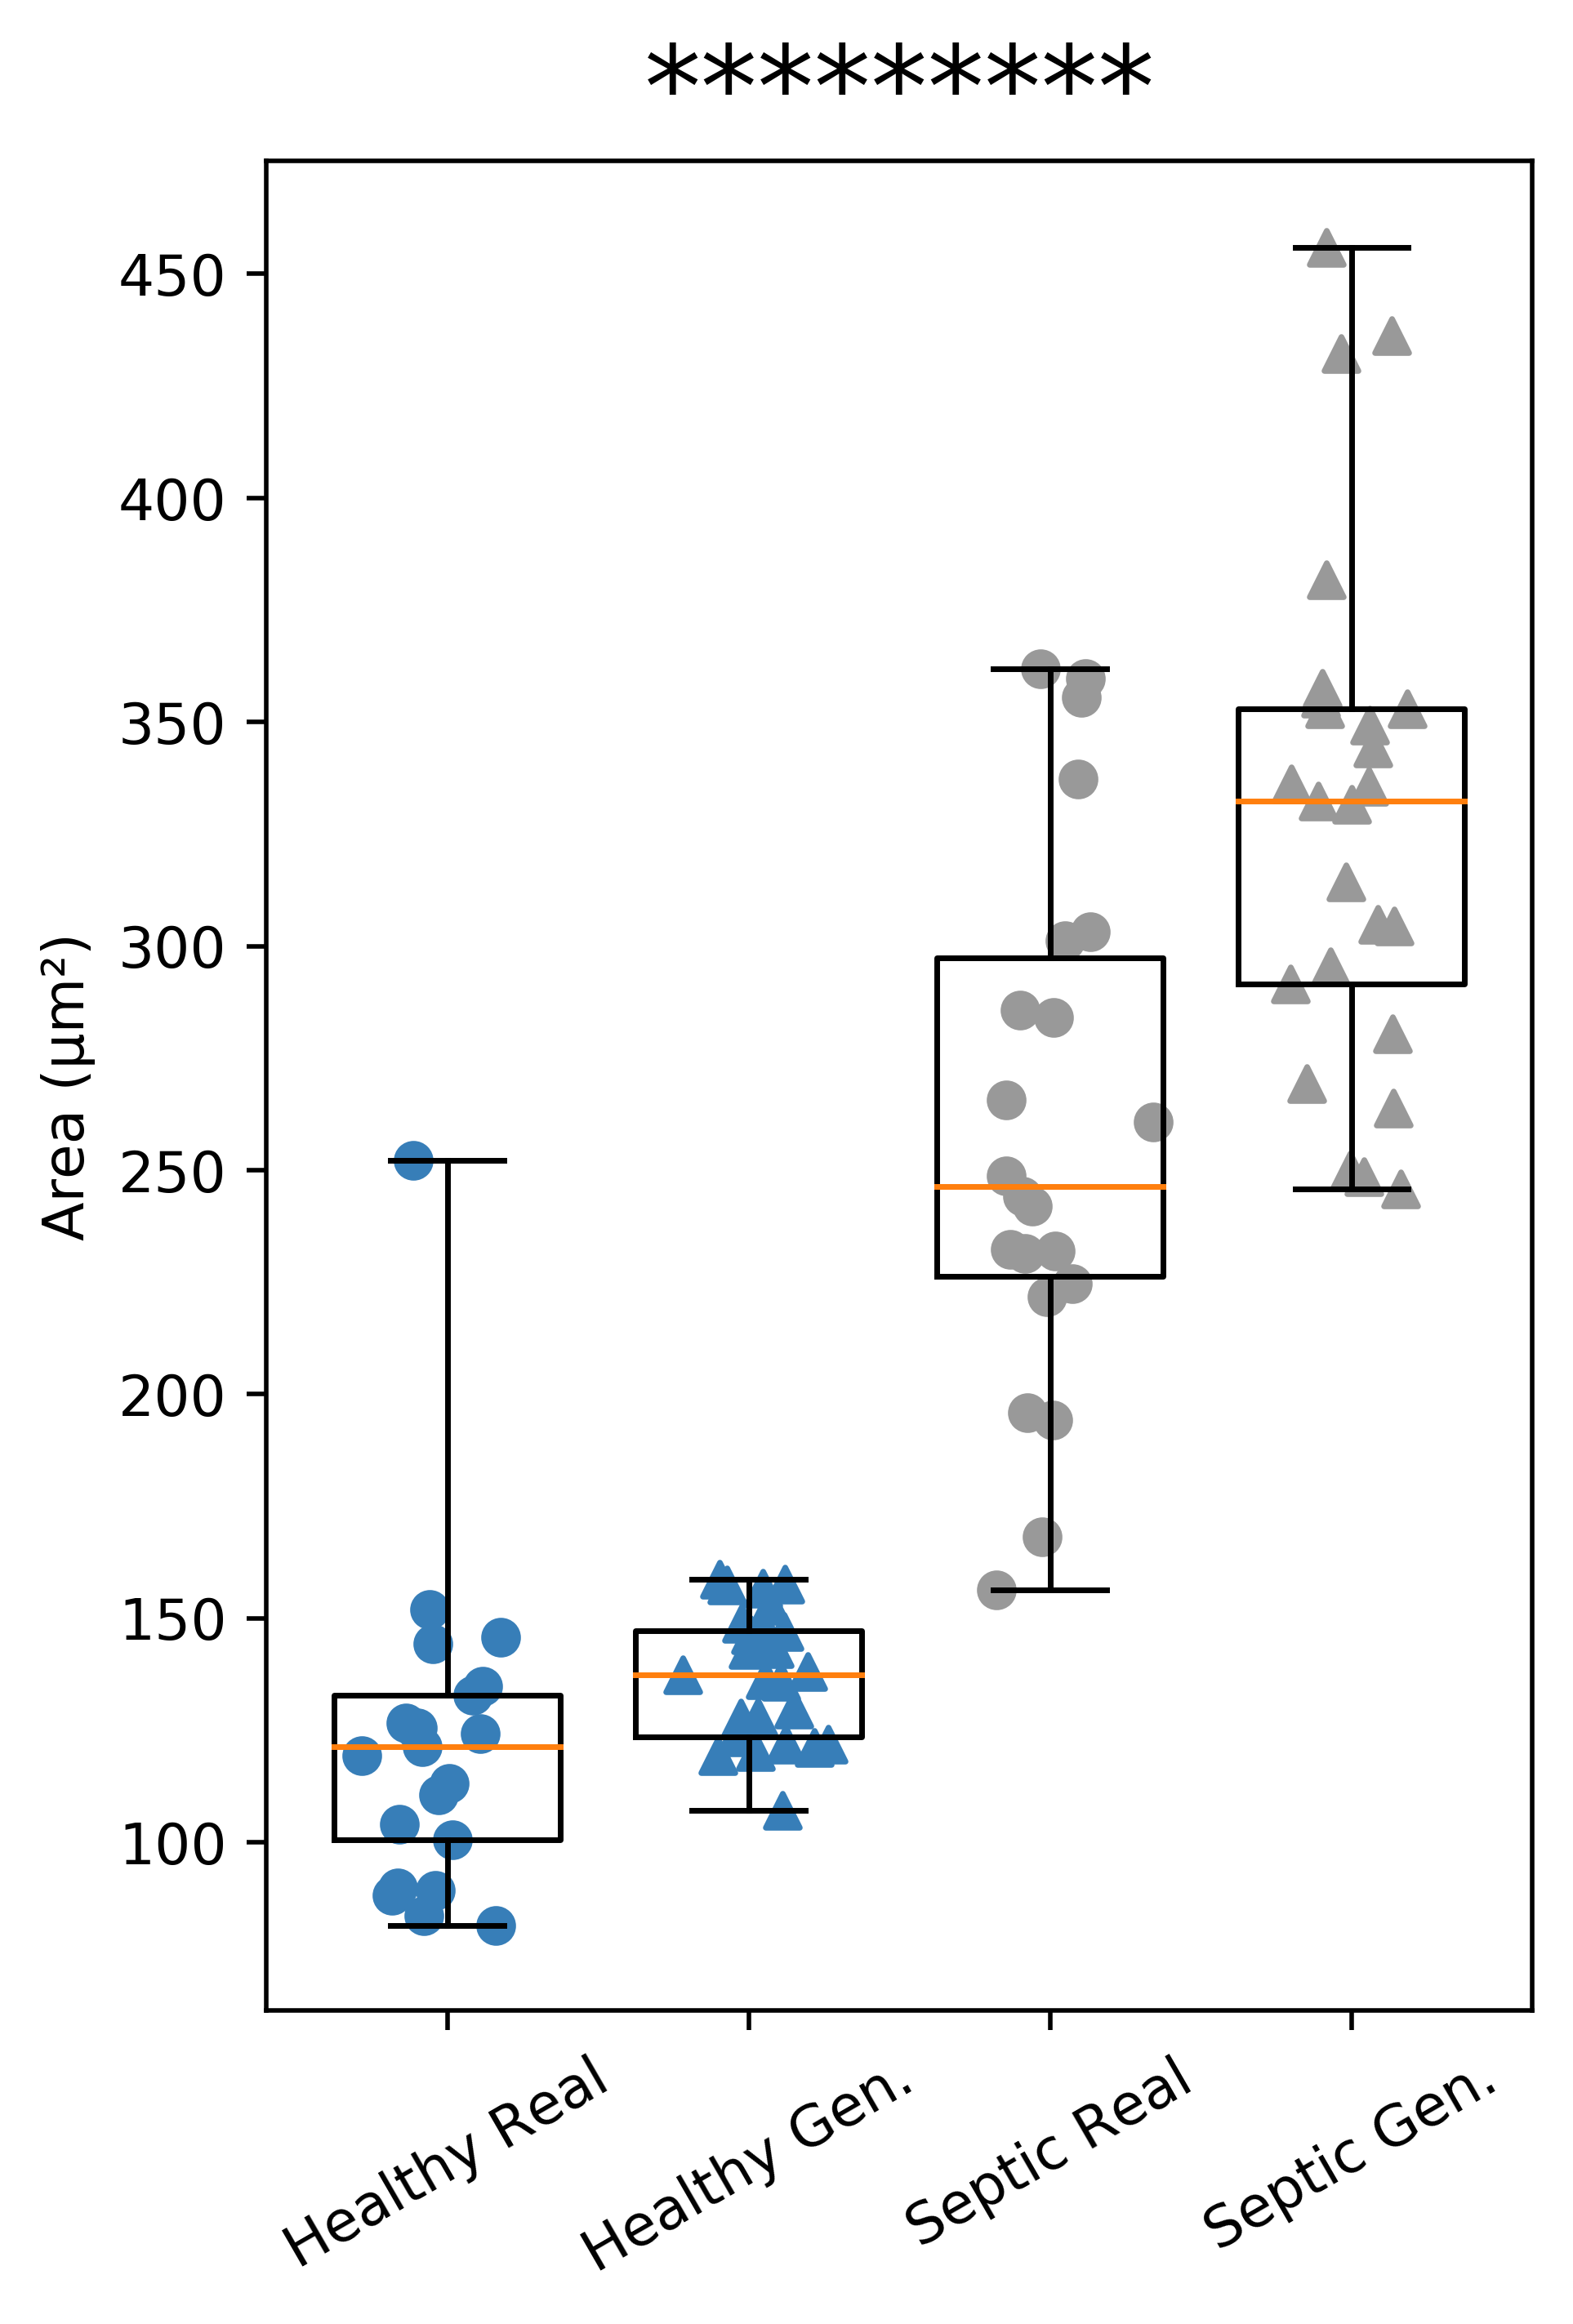

In [49]:
hr = df_hr[['area1']]
hr.columns = ['Healthy Real']
hg = df_hg[['area1']]
hg.columns = ['Healthy Gen.']
sr = df_sr[['area1']]
sr.columns = ['Septic Real']
sg = df_sg[['area1']]
sg.columns = ['Septic Gen.']

color = ['#377eb8', '#377eb8', '#999999', '#999999']
marker = ['o', '^', 'o', '^']

datasets = [hr, hg, sr, sg]
# Set x-positions for boxes
x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
x_pos = (x_pos_range * 0.5)
# Plot
plt.figure(figsize=(4,6), dpi=500)
for i, data in enumerate(datasets):
    bp = plt.boxplot(
        np.array(data), sym='', whis=[0, 100], widths=0.5 / len(datasets),
        labels=list(datasets[i]),
        positions=[x_pos[i] + j * 1 for j in range(len(data.T))]
    )
    y = data
    x = np.random.normal(x_pos[i], 0.02, len(y))
    scatter = plt.scatter(x,y, c=color[i], marker = marker[i])
# Titles
plt.title('*********', fontsize=20)
plt.ylabel('Area '+ u"(\u03bcm²)")
plt.xticks(rotation=30)
plt.xlim(-0.1,0.6)
#plt.text(-0.25, 350, 'p = 2.69e-27')
plt.savefig("area_dist.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [25]:
x_pos

array([0.        , 0.16666667, 0.33333333, 0.5       ])

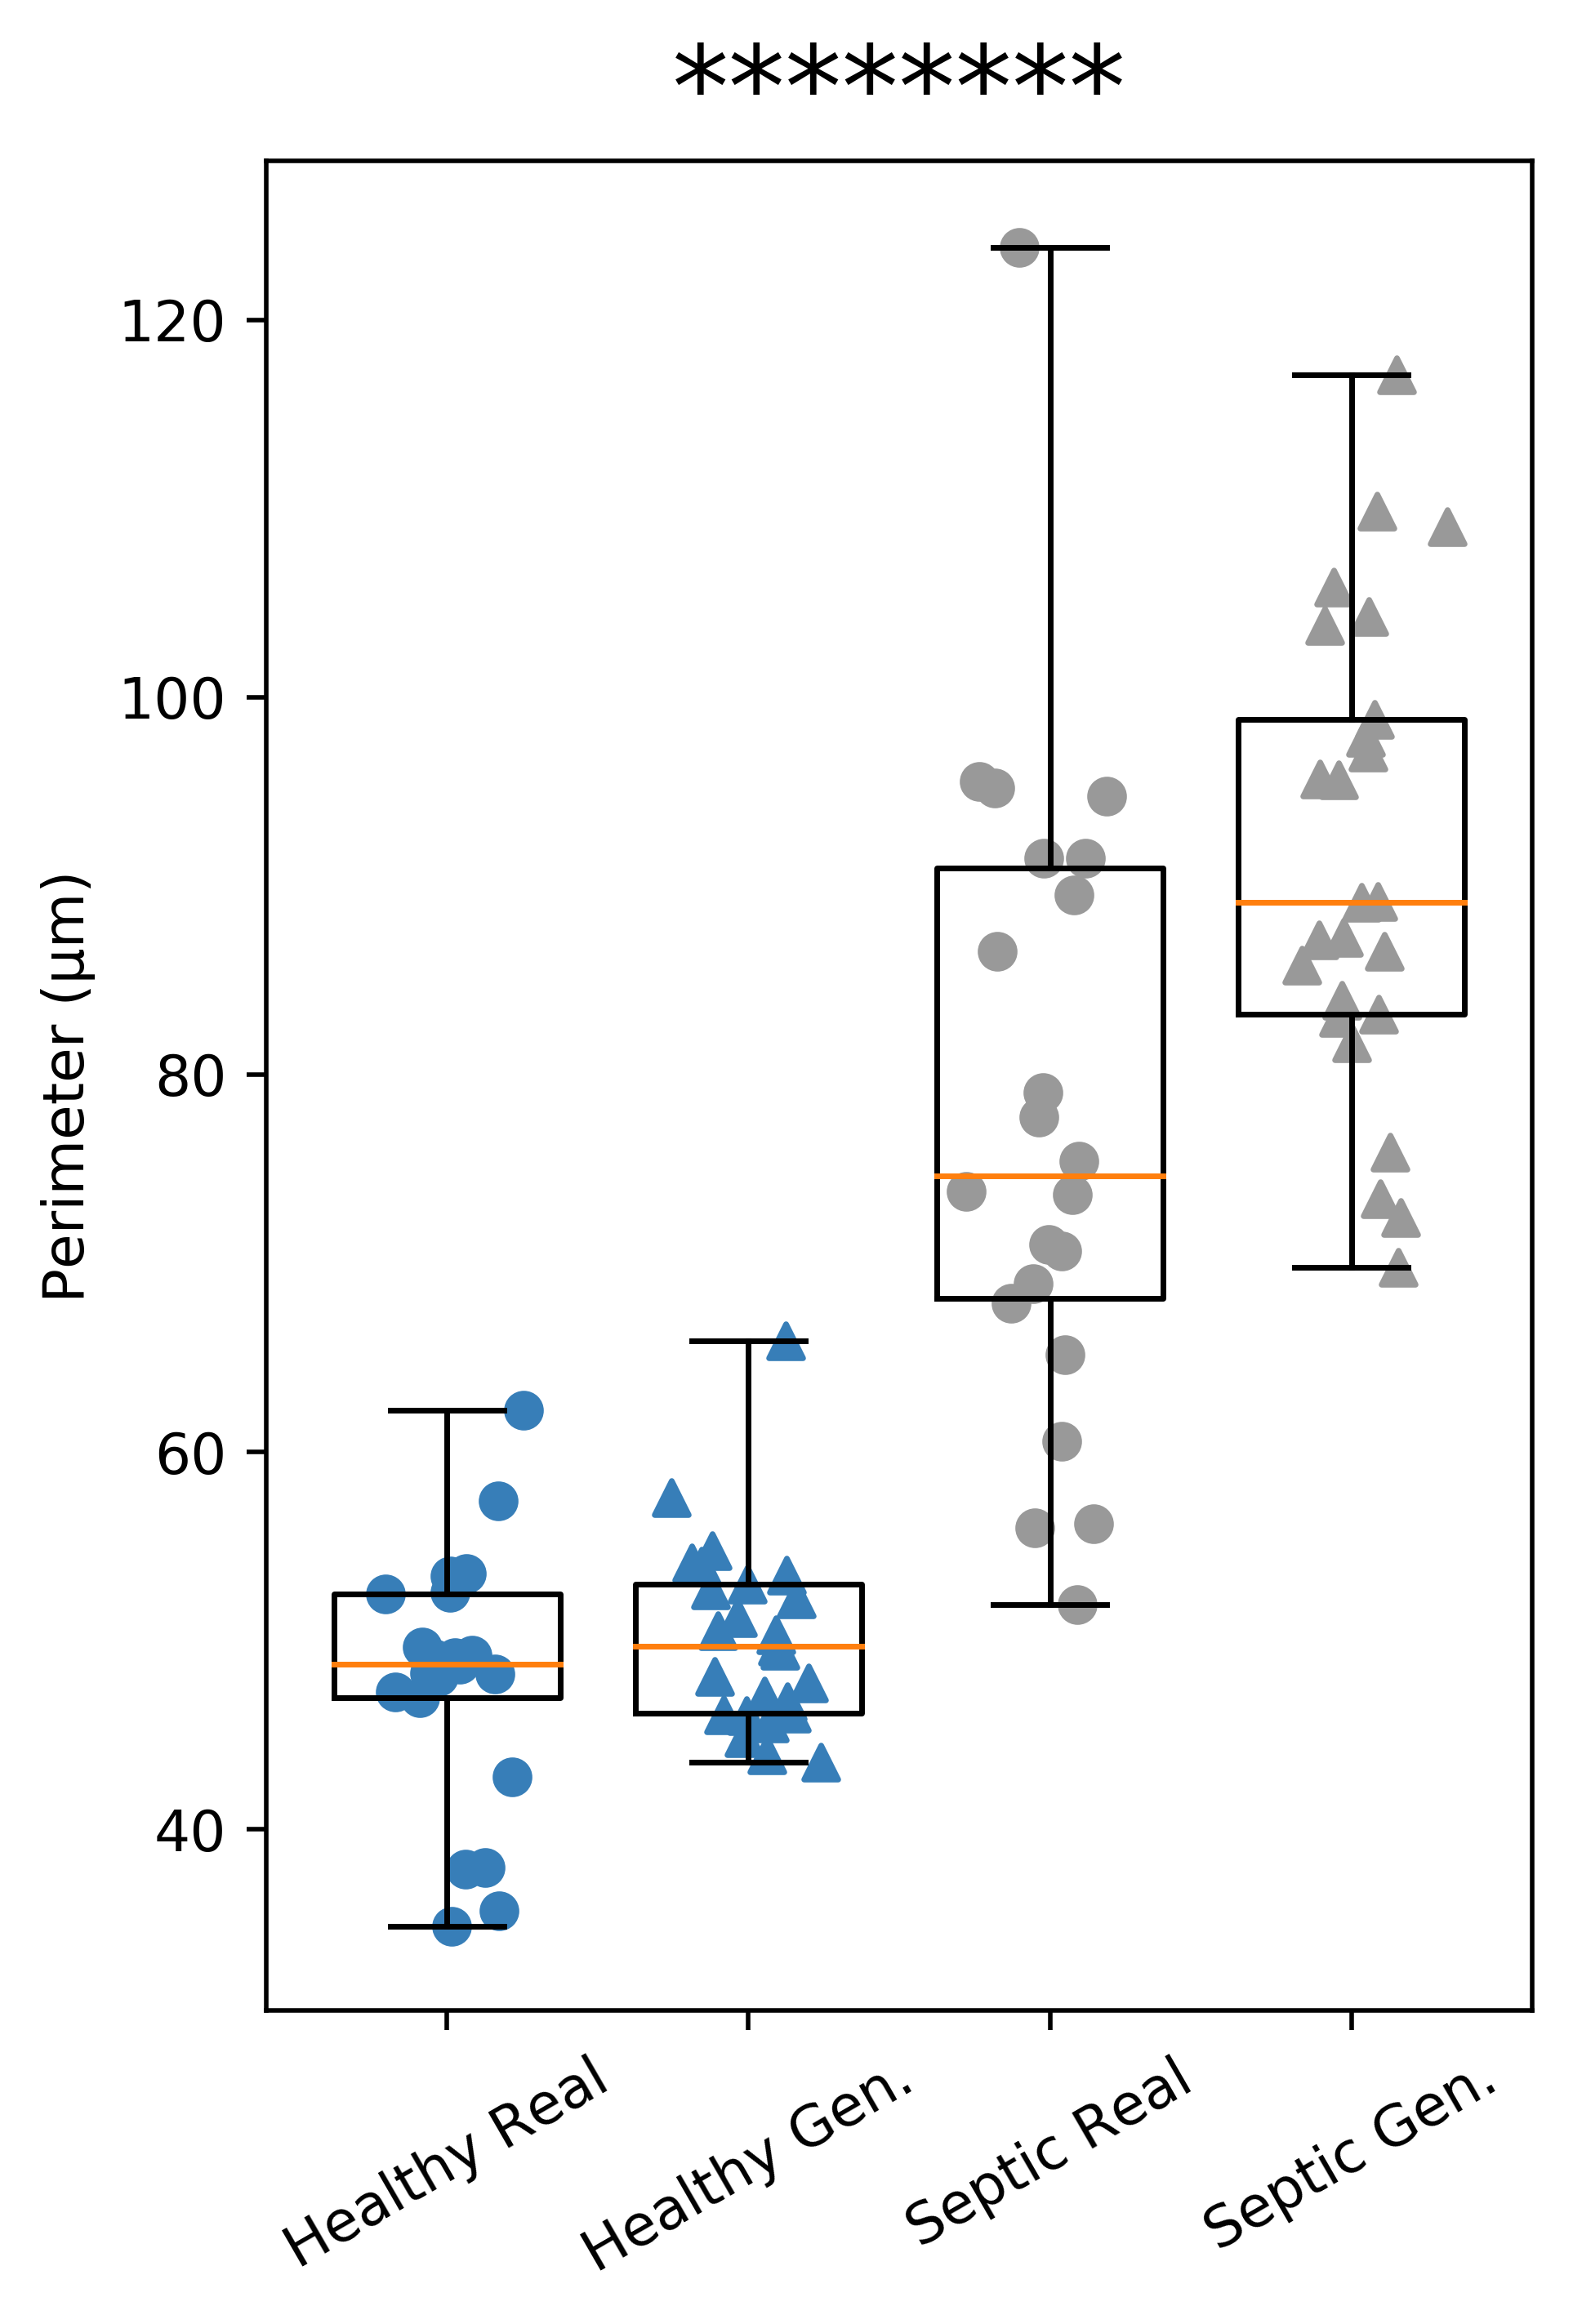

In [50]:
hr = df_hr[['perimeter1']]
hr.columns = ['Healthy Real']
hg = df_hg[['perimeter1']]
hg.columns = ['Healthy Gen.']
sr = df_sr[['perimeter1']]
sr.columns = ['Septic Real']
sg = df_sg[['perimeter1']]
sg.columns = ['Septic Gen.']

color = ['#377eb8', '#377eb8', '#999999', '#999999']
marker = ['o', '^', 'o', '^']

datasets = [hr, hg, sr, sg]
# Set x-positions for boxes
x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
x_pos = (x_pos_range * 0.5)
# Plot
plt.figure(figsize=(4,6), dpi=500)
for i, data in enumerate(datasets):
    bp = plt.boxplot(
        np.array(data), sym='', whis=[0, 100], widths=0.5 / len(datasets),
        labels=list(datasets[i]),
        positions=[x_pos[i] + j * 1 for j in range(len(data.T))]
    )
    y = data
    x = np.random.normal(x_pos[i], 0.02, len(y))
    scatter = plt.scatter(x,y, c=color[i], marker = marker[i])
# Titles
plt.title('********', fontsize=20)
plt.ylabel('Perimeter '+ u"(\u03bcm)")
plt.xticks(rotation=30)
plt.xlim(-0.1,0.6)
#plt.text(-0.25, 350, 'p = 2.69e-27')
plt.savefig("perimeter_dist.pdf", format="pdf", bbox_inches='tight')
plt.show()

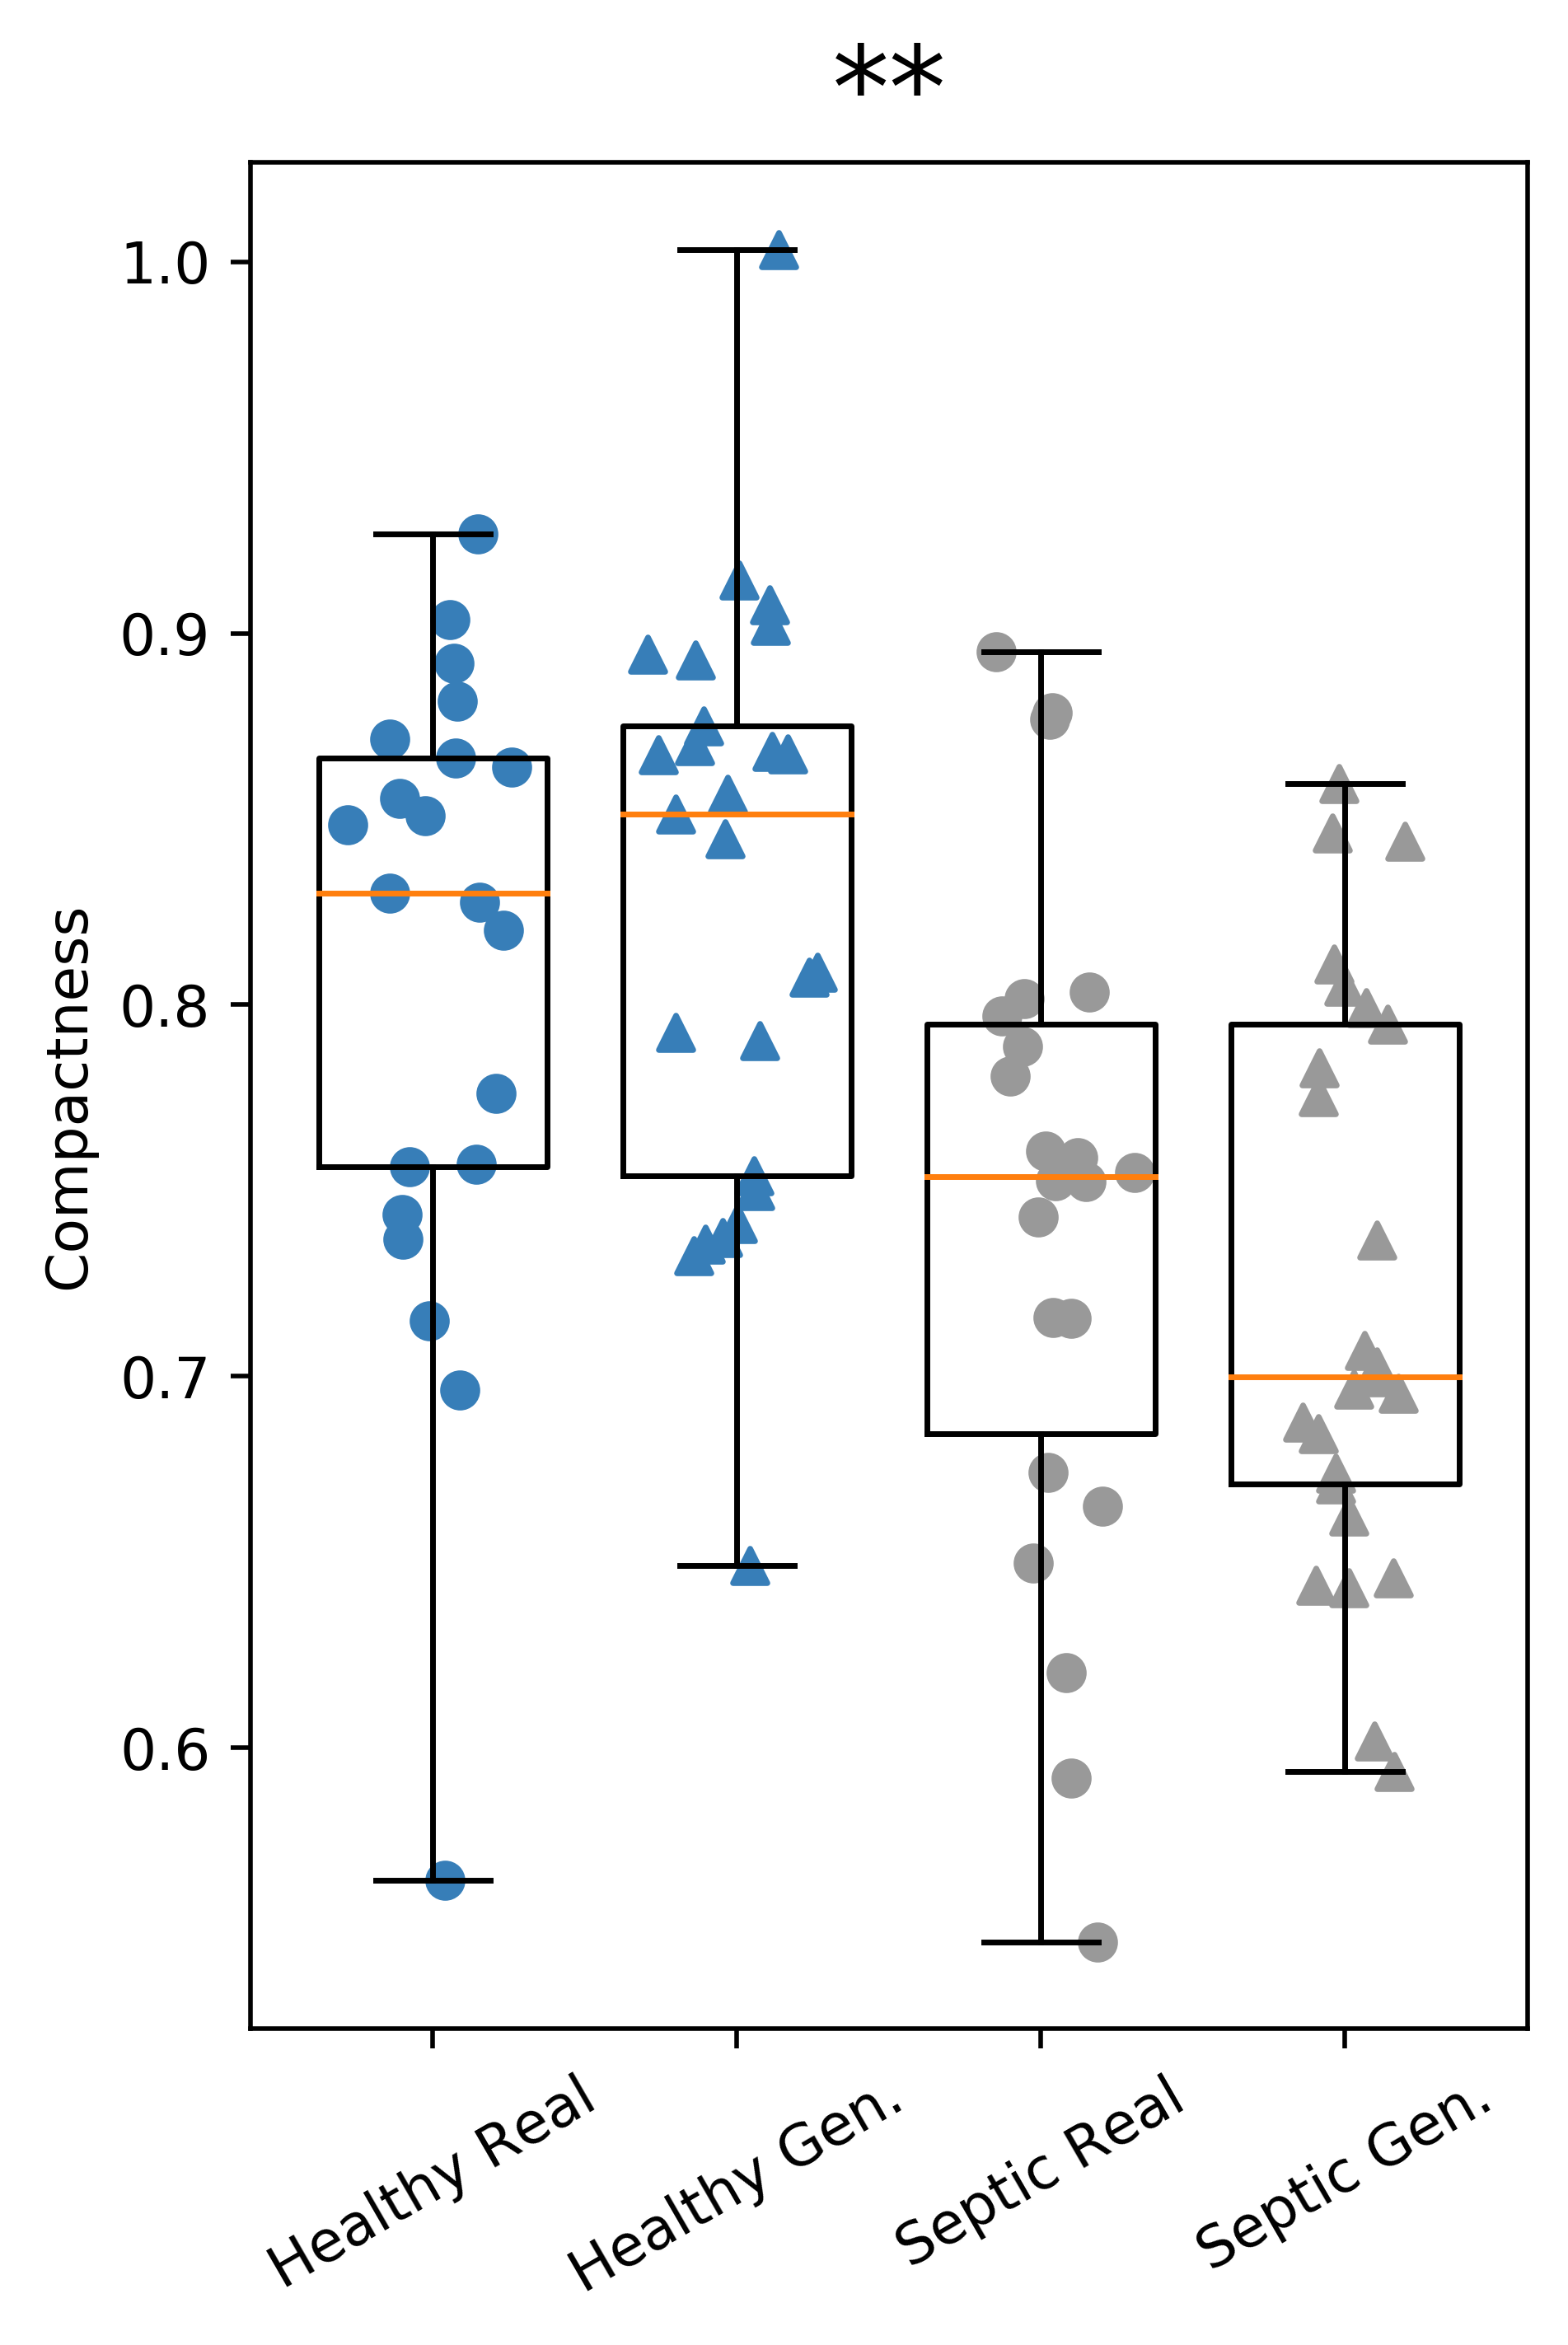

In [51]:
hr = df_hr[['shape_compactness1']]
hr.columns = ['Healthy Real']
hg = df_hg[['shape_compactness1']]
hg.columns = ['Healthy Gen.']
sr = df_sr[['shape_compactness1']]
sr.columns = ['Septic Real']
sg = df_sg[['shape_compactness1']]
sg.columns = ['Septic Gen.']

color = ['#377eb8', '#377eb8', '#999999', '#999999']
marker = ['o', '^', 'o', '^']

datasets = [hr, hg, sr, sg]
# Set x-positions for boxes
x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
x_pos = (x_pos_range * 0.5)
# Plot
plt.figure(figsize=(4,6), dpi=500)
for i, data in enumerate(datasets):
    bp = plt.boxplot(
        np.array(data), sym='', whis=[0, 100], widths=0.5 / len(datasets),
        labels=list(datasets[i]),
        positions=[x_pos[i] + j * 1 for j in range(len(data.T))]
    )
    y = data
    x = np.random.normal(x_pos[i], 0.02, len(y))
    scatter = plt.scatter(x,y, c=color[i], marker = marker[i])
# Titles
plt.title('**', fontsize=20)
plt.ylabel("Compactness")
plt.xticks(rotation=30)
plt.xlim(-0.1,0.6)
#plt.text(-0.25, 350, 'p = 2.69e-27')
plt.savefig("compactness_dist.pdf", format="pdf", bbox_inches='tight')
plt.show()

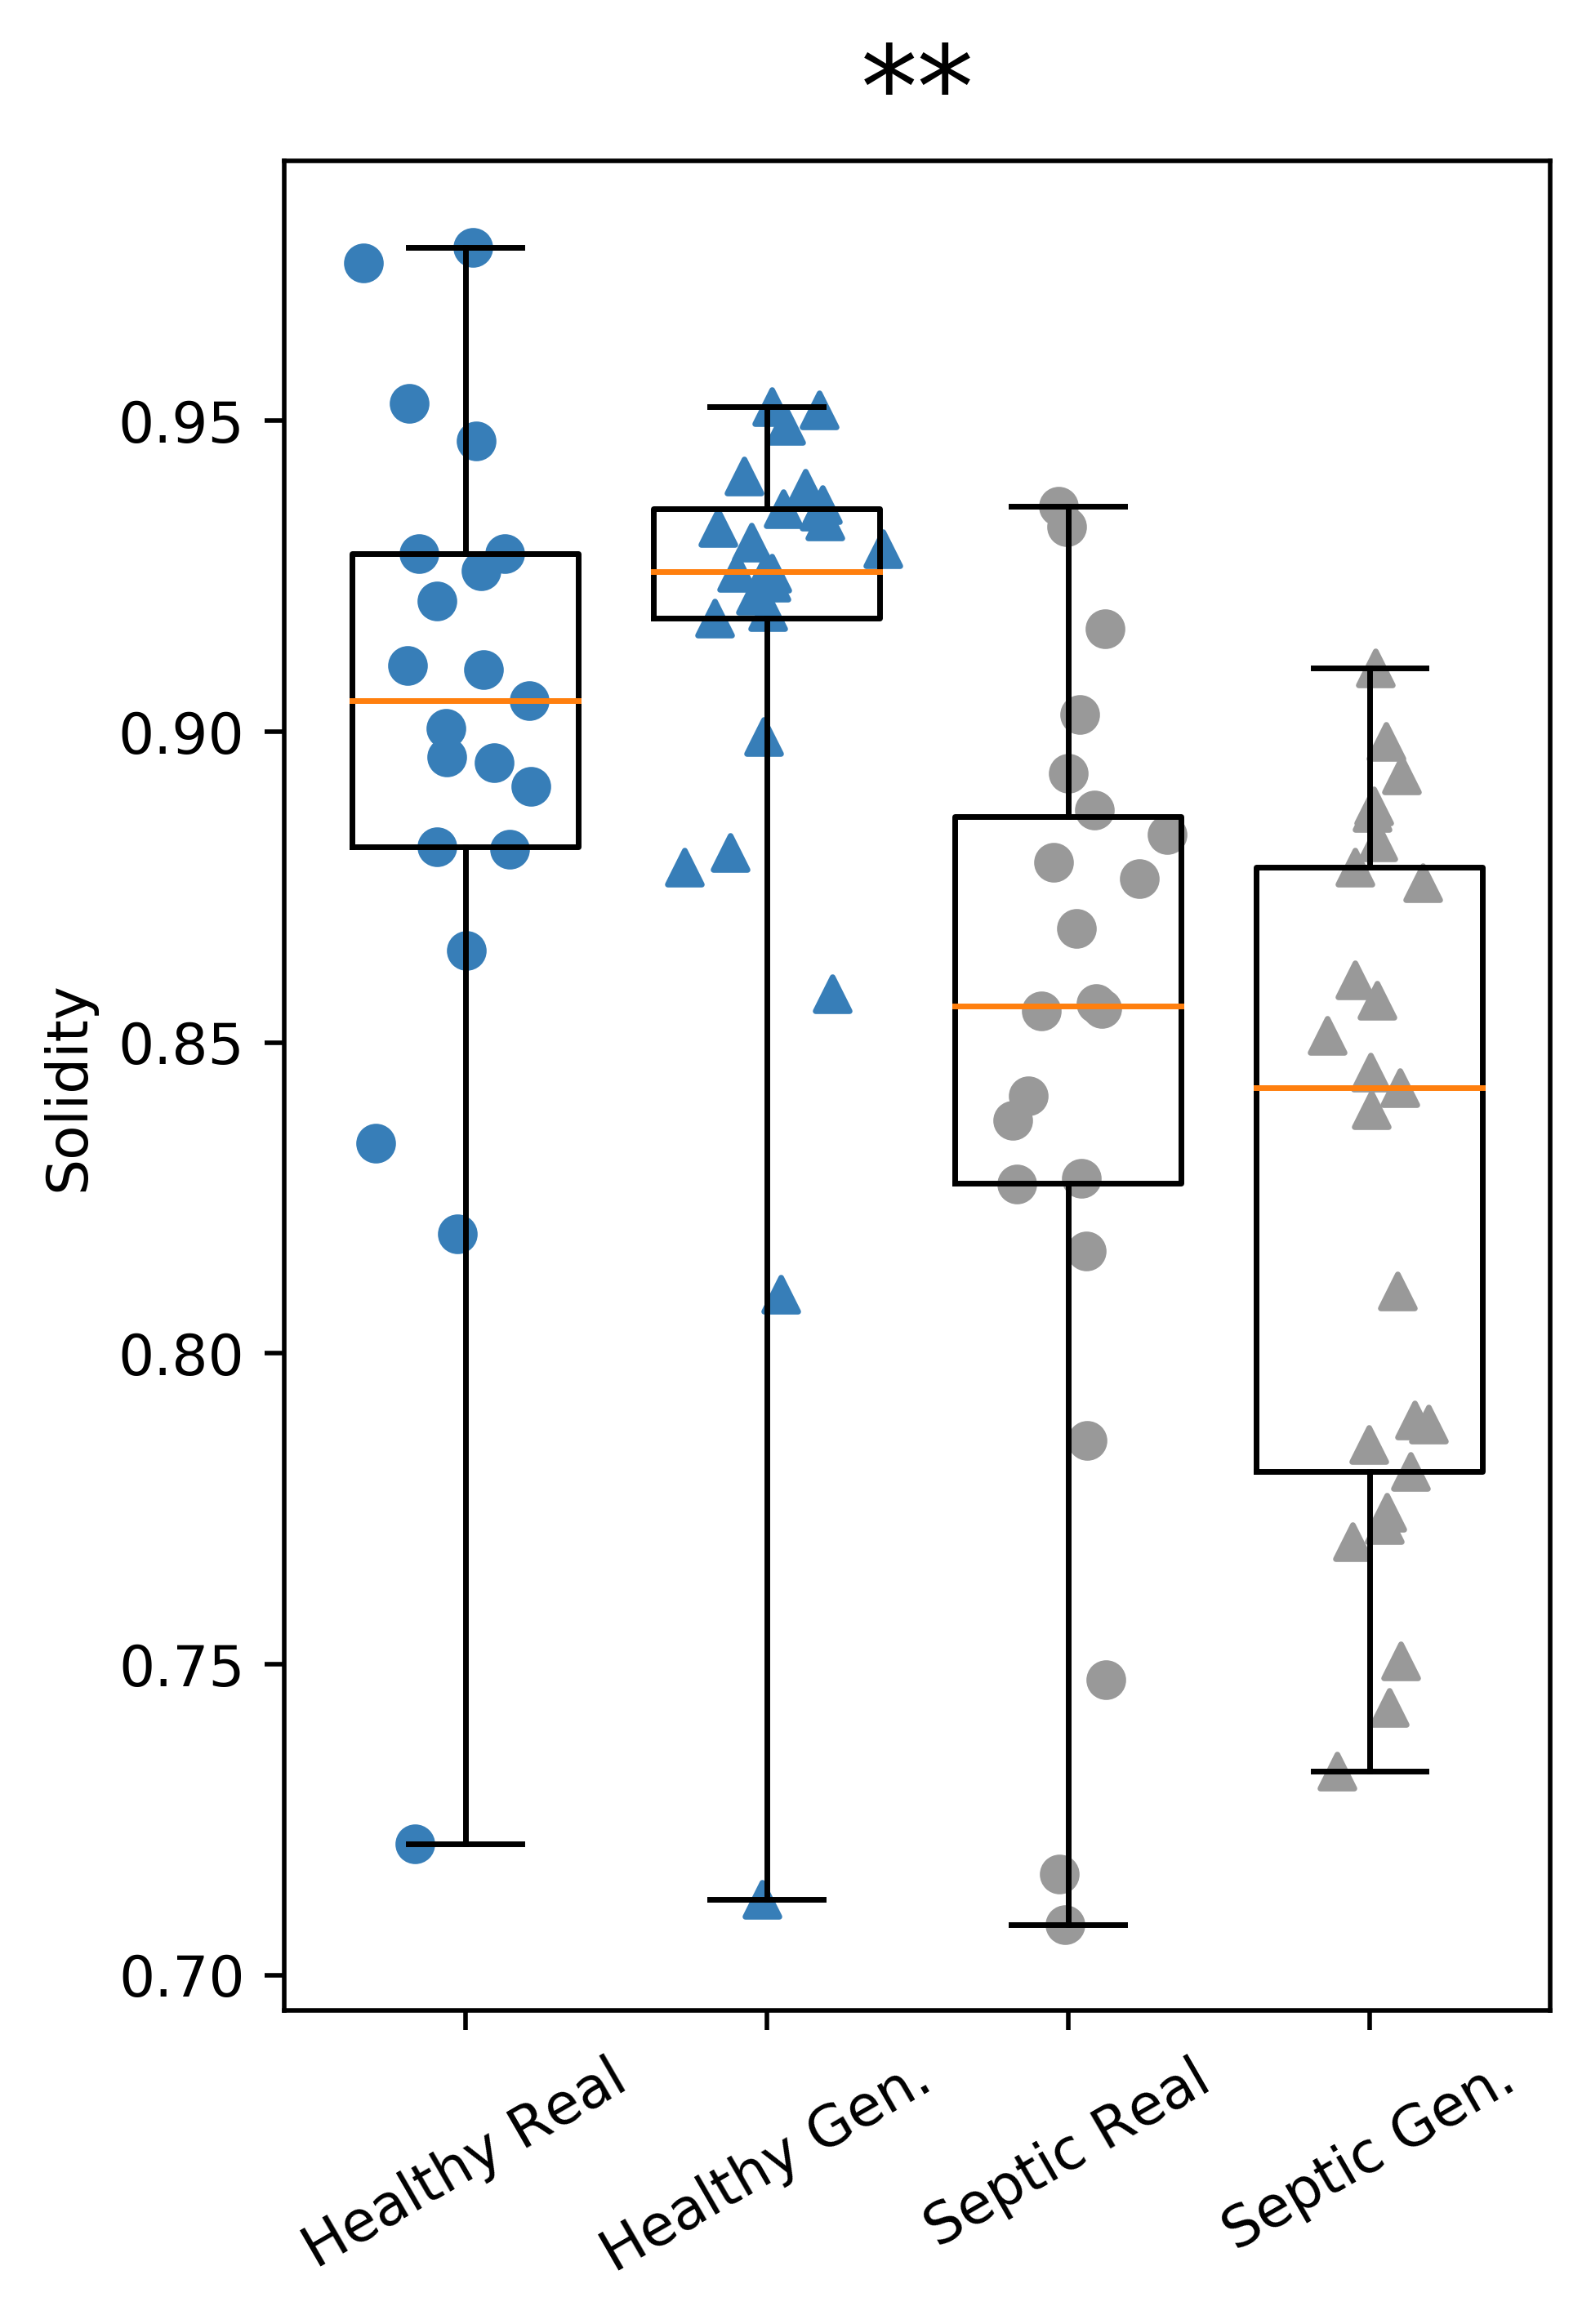

In [52]:
hr = df_hr[['shape_solidity1']]
hr.columns = ['Healthy Real']
hg = df_hg[['shape_solidity1']]
hg.columns = ['Healthy Gen.']
sr = df_sr[['shape_solidity1']]
sr.columns = ['Septic Real']
sg = df_sg[['shape_solidity1']]
sg.columns = ['Septic Gen.']

color = ['#377eb8', '#377eb8', '#999999', '#999999']
marker = ['o', '^', 'o', '^']

datasets = [hr, hg, sr, sg]
# Set x-positions for boxes
x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
x_pos = (x_pos_range * 0.5)
# Plot
plt.figure(figsize=(4,6), dpi=500)
for i, data in enumerate(datasets):
    bp = plt.boxplot(
        np.array(data), sym='', whis=[0, 100], widths=0.5 / len(datasets),
        labels=list(datasets[i]),
        positions=[x_pos[i] + j * 1 for j in range(len(data.T))]
    )
    y = data
    x = np.random.normal(x_pos[i], 0.02, len(y))
    scatter = plt.scatter(x,y, c=color[i], marker = marker[i])
# Titles
plt.title('**', fontsize=20)
plt.ylabel("Solidity")
plt.xticks(rotation=30)
plt.xlim(-0.1,0.6)
#plt.text(-0.25, 350, 'p = 2.69e-27')
plt.savefig("solidity_dist.pdf", format="pdf", bbox_inches='tight')
plt.show()

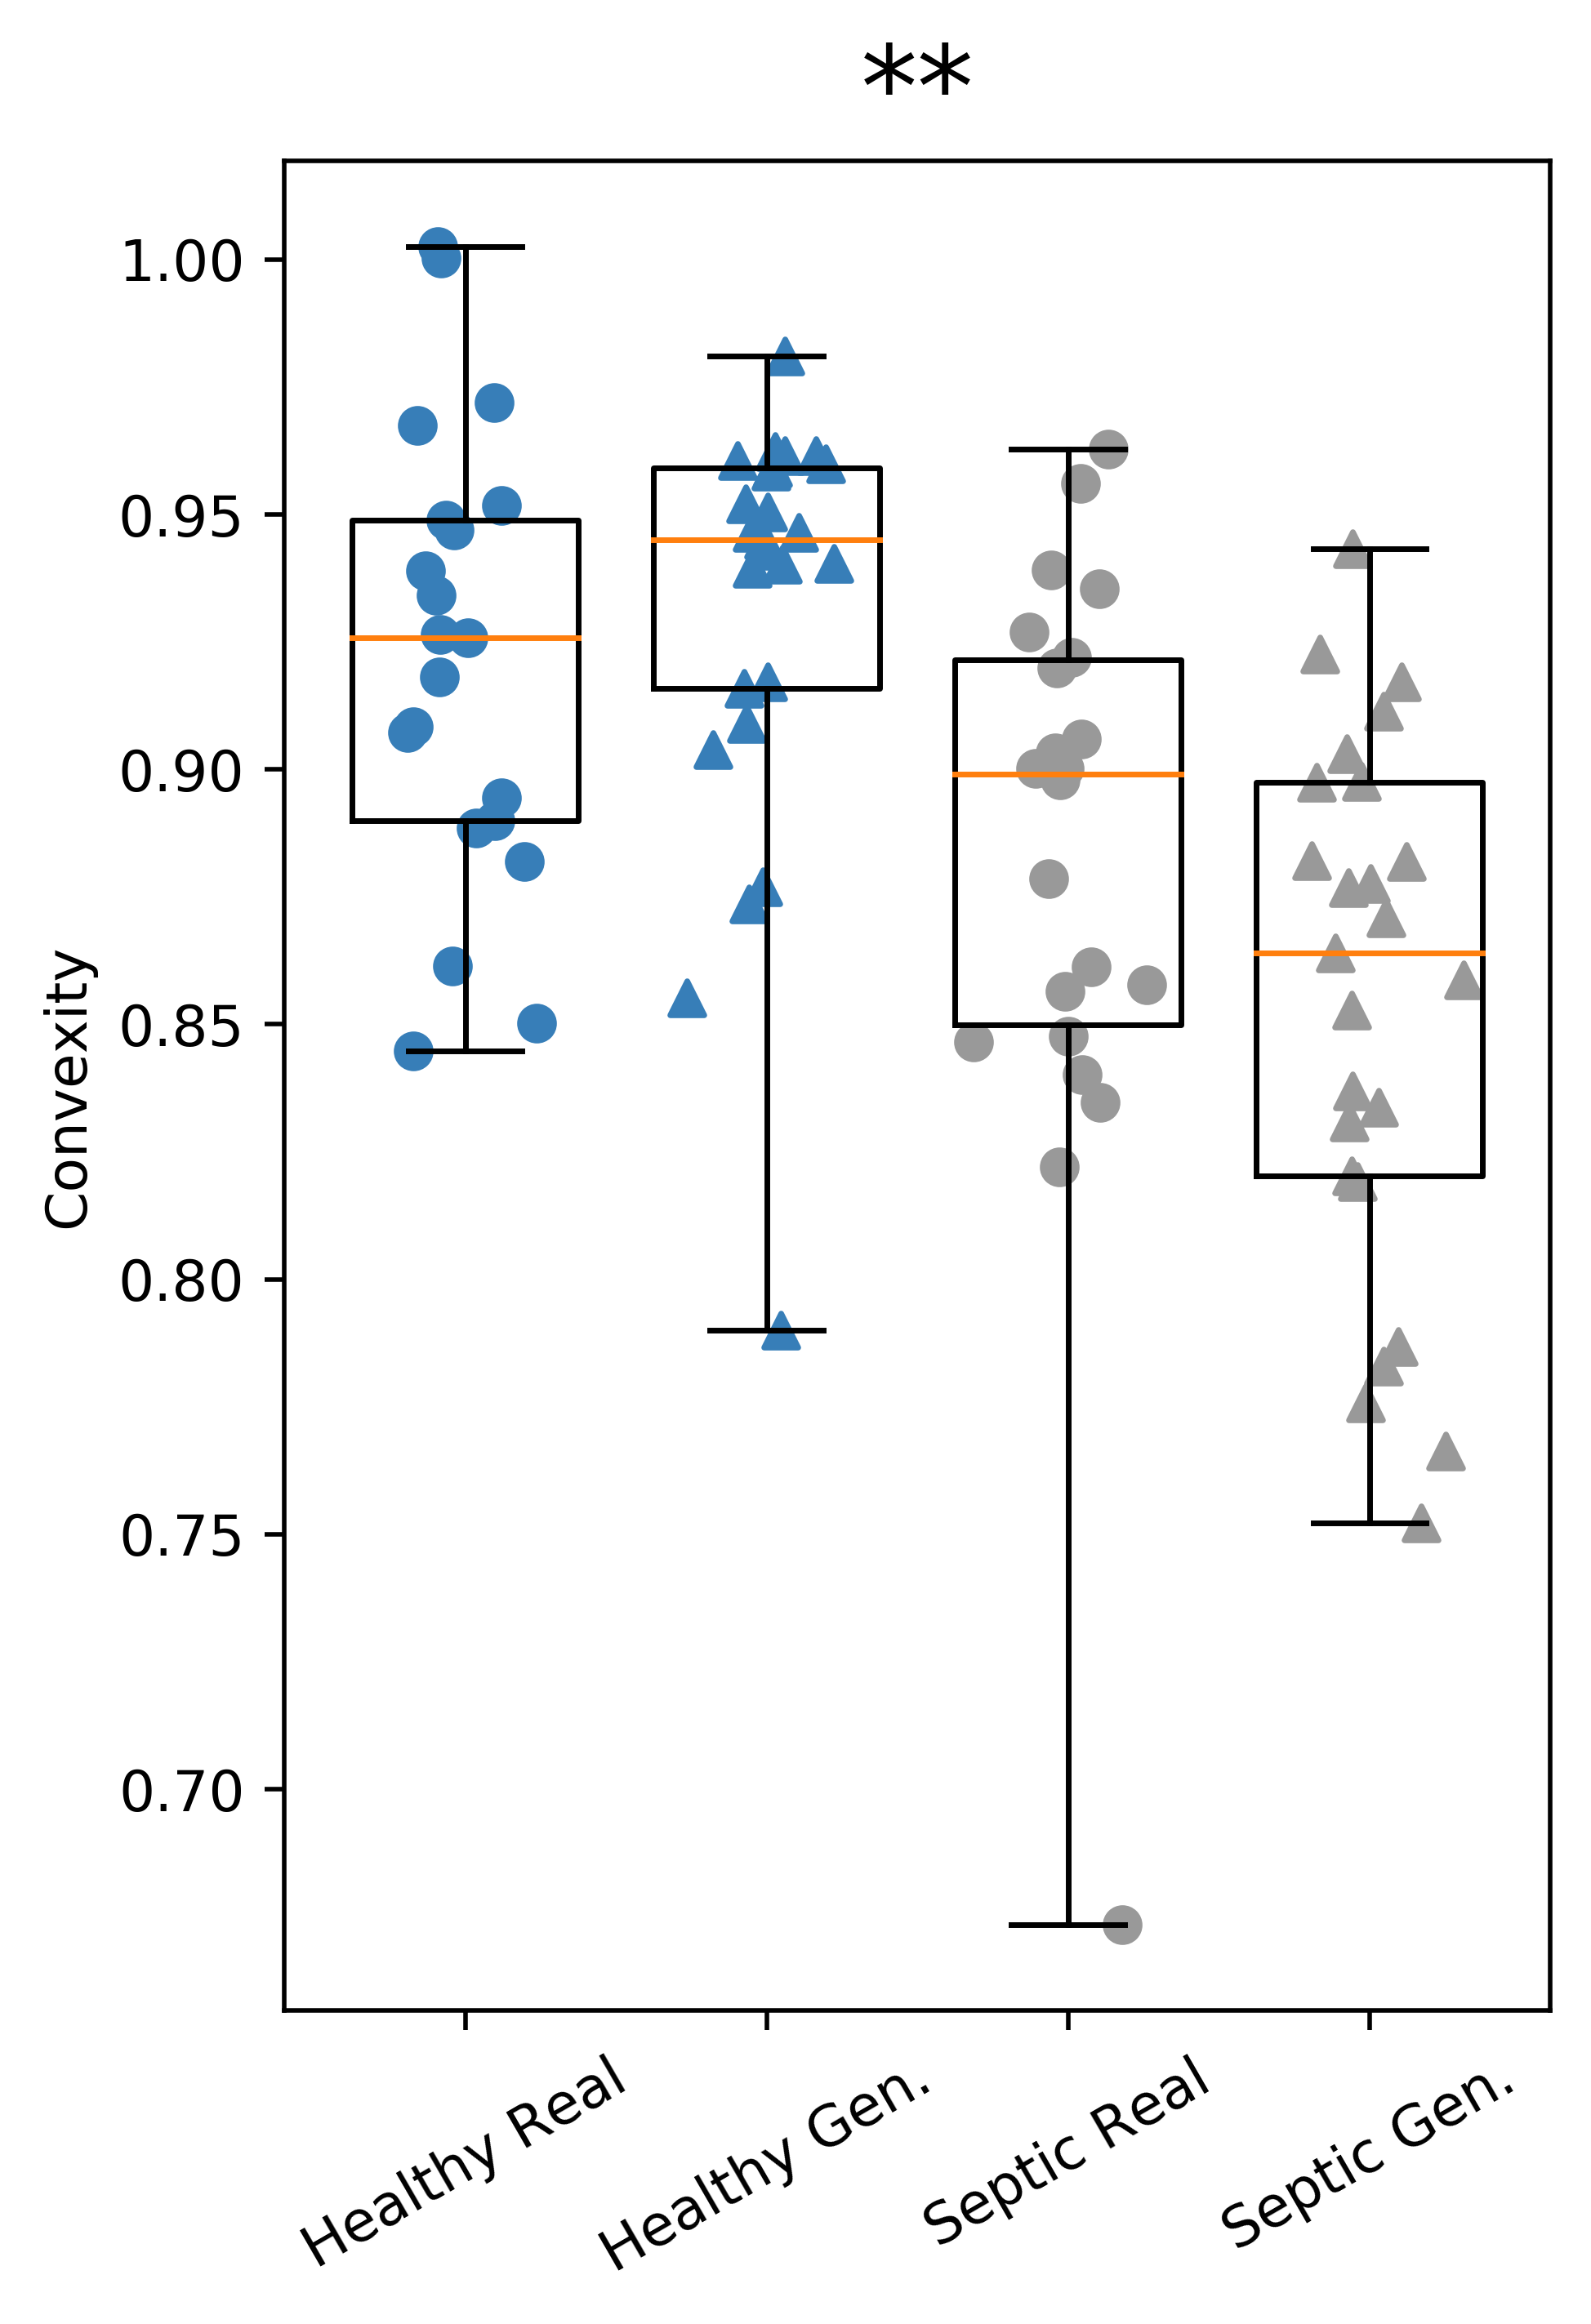

In [53]:
hr = df_hr[['shape_convexity1']]
hr.columns = ['Healthy Real']
hg = df_hg[['shape_convexity1']]
hg.columns = ['Healthy Gen.']
sr = df_sr[['shape_convexity1']]
sr.columns = ['Septic Real']
sg = df_sg[['shape_convexity1']]
sg.columns = ['Septic Gen.']

color = ['#377eb8', '#377eb8', '#999999', '#999999']
marker = ['o', '^', 'o', '^']

datasets = [hr, hg, sr, sg]
# Set x-positions for boxes
x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
x_pos = (x_pos_range * 0.5)
# Plot
plt.figure(figsize=(4,6), dpi=500)
for i, data in enumerate(datasets):
    bp = plt.boxplot(
        np.array(data), sym='', whis=[0, 100], widths=0.5 / len(datasets),
        labels=list(datasets[i]),
        positions=[x_pos[i] + j * 1 for j in range(len(data.T))]
    )
    y = data
    x = np.random.normal(x_pos[i], 0.02, len(y))
    scatter = plt.scatter(x,y, c=color[i], marker = marker[i])
# Titles
plt.title('**', fontsize=20)
plt.ylabel("Convexity")
plt.xticks(rotation=30)
plt.xlim(-0.1,0.6)
#plt.text(-0.25, 350, 'p = 2.69e-27')
plt.savefig("convexity_dist.pdf", format="pdf", bbox_inches='tight')
plt.show()

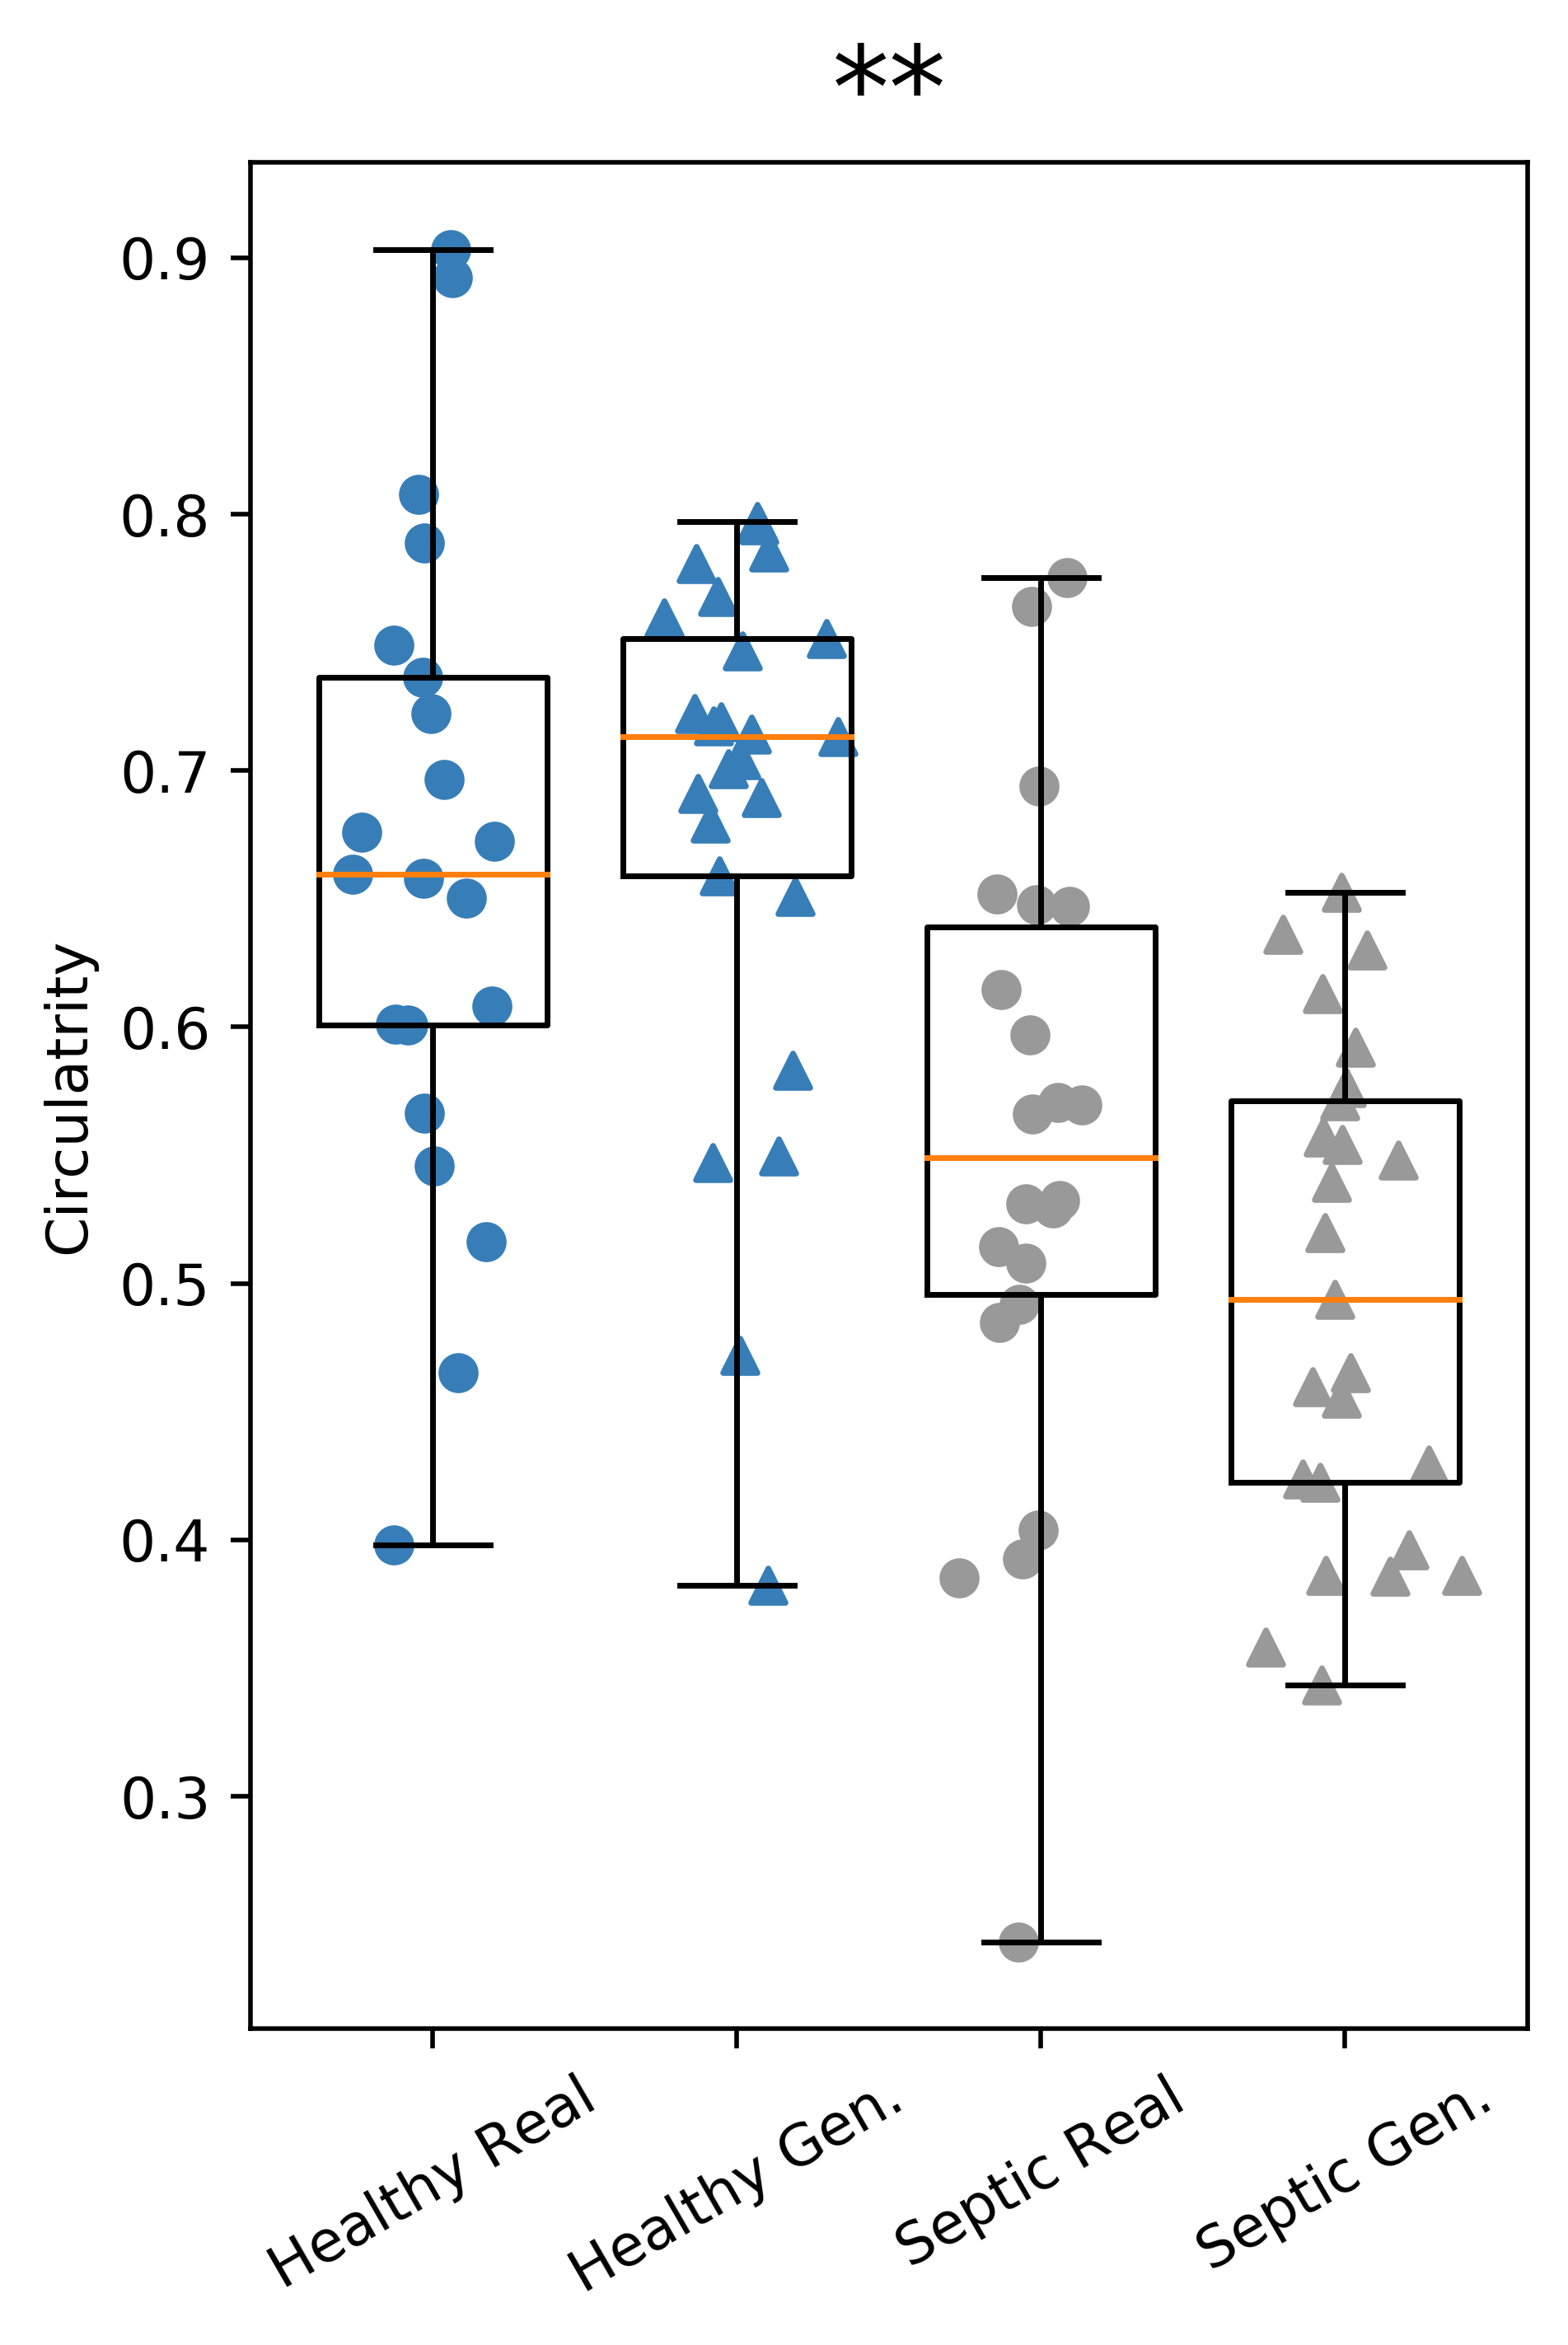

In [54]:
hr = df_hr[['shape_circularity1']]
hr.columns = ['Healthy Real']
hg = df_hg[['shape_circularity1']]
hg.columns = ['Healthy Gen.']
sr = df_sr[['shape_circularity1']]
sr.columns = ['Septic Real']
sg = df_sg[['shape_circularity1']]
sg.columns = ['Septic Gen.']

color = ['#377eb8', '#377eb8', '#999999', '#999999']
marker = ['o', '^', 'o', '^']

datasets = [hr, hg, sr, sg]
# Set x-positions for boxes
x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
x_pos = (x_pos_range * 0.5)
# Plot
plt.figure(figsize=(4,6), dpi=500)
for i, data in enumerate(datasets):
    bp = plt.boxplot(
        np.array(data), sym='', whis=[0, 100], widths=0.5 / len(datasets),
        labels=list(datasets[i]),
        positions=[x_pos[i] + j * 1 for j in range(len(data.T))]
    )
    y = data
    x = np.random.normal(x_pos[i], 0.02, len(y))
    scatter = plt.scatter(x,y, c=color[i], marker = marker[i])
# Titles
plt.title('**', fontsize=20)
plt.ylabel('Circulatrity')
plt.xticks(rotation=30)
plt.xlim(-0.1,0.6)
#plt.text(-0.25, 350, 'p = 2.69e-27')
plt.savefig("circularity_dist.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [151]:
df

,index,cid,area1,perim_1sqrt21,equiv_diameter1,perimeter1,poly_perim1,poly_area1,ellipse_centroid_x1,ellipse_centroid_y1,...,origin,CellID_EXP,fullfilepath,witheld,class_label,MRAE1,MRAE2,true_lab,label_2,label_5
0,0,1,-0.638406,-0.648981,-0.587082,-0.635938,-0.643277,-0.640187,826.367588,829.056267,...,Real,LPS_1-5kPa_2020-07-01_xy01_A,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.047962,0.038834,1,1,1
1,1,2,-0.814073,-0.719328,-0.804347,-0.686729,-0.678357,-0.818053,826.561800,827.330169,...,Real,LPS_1-5kPa_2020-07-01_xy03_A,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.046024,0.026863,1,1,1
2,2,3,-0.923044,-0.464640,-0.946125,-0.458204,-0.457991,-0.921165,827.111913,830.122424,...,Real,LPS_1-5kPa_2020-07-01_xy03_B,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.030017,-0.071271,1,1,4
3,3,4,-1.129957,-1.356736,-1.233139,-1.356700,-1.354336,-1.131311,828.660187,828.479577,...,Real,LPS_1-5kPa_2020-07-01_xy07_A,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.125071,0.005754,1,1,1
4,4,5,-0.914116,-0.882978,-0.934287,-0.886987,-0.895353,-0.914370,829.403602,827.704257,...,Real,LPS_1-5kPa_2020-07-01_xy08_B,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Healthy_Real_N,0.070767,0.008368,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,20,21,1.245083,1.455999,1.232593,1.457286,1.456910,1.245831,506.708292,509.105347,...,Gen,Gen5,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Septic_Gen_N,-0.096568,-0.007695,0,0,2
89,21,22,1.423638,1.814126,1.375062,1.780820,1.790584,1.428924,513.526217,507.696860,...,Gen,Gen6,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Septic_Gen_N,-0.149838,0.073257,0,0,3
90,22,23,1.470377,1.428079,1.411771,1.412832,1.431388,1.468849,507.223455,511.825302,...,Gen,Gen7,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Septic_Gen_N,-0.102101,0.011087,0,0,2
91,23,24,1.385038,1.021724,1.344566,1.009694,1.014513,1.381876,507.760959,511.218810,...,Gen,Gen8,./data/ewinn/ashape_tests2D/train_test_split/1...,N,Septic_Gen_N,-0.078468,0.097368,0,0,0
